## Privacy Policies Classification
### Author: Valentina Chacon Buitrago

Removed 8 rogue policies containing the same template from Go Daddy, policies removed:

- 12. Begin2Search
- 20. DashBar
- 26. FileFreedom
- 27. FizzleWizzleToolbar
- 31. GotSmiley
- 37. OneToolbar
- 44. ScreenScenes
- 52. VoondaToolbar

In [1]:
import os
from os import listdir
from os.path import abspath, isfile, join
import numpy as np
import re
from sklearn.datasets import load_files
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import pickle
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Valentina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/Valentina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
page_data = load_files(os.path.abspath('privacy_policies_fixed'))
x,y = page_data.data, page_data.target

##### Text Preprocessing

In [3]:
documents = []

stemmer = WordNetLemmatizer()
stop_words = stopwords.words('english')

for i in range(len(x)):
    # Remove all break line characters
    document = str(x[i], 'mac_roman')

    # Remove all the special characters
    document = re.sub(r'\W', ' ', document)
    
    # Remove all single characters 
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove all numbers
    document = re.sub(r'\d+', '', document)
   
    # Substitute multiple spaces with a single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Convert document to lowercase
    document = document.lower()
    
    # Lemmatization and stop words removal
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = [word for word in document if word not in stop_words]
    
    document = ' '.join(document)
    
    # Remove all single characters (removes remaining u after lemmatization of word us)
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    documents.append(document) 

##### Classifiers

In [4]:
classifiers = {
    'random_forest': RandomForestClassifier,
    'SGD': SGDClassifier,
    'k_neighbors': KNeighborsClassifier,
    'gaussian_process': GaussianProcessClassifier}

### Experiment 1. Modify single parameters with the default configuration of each classifier
Classifiers being tested are:
- Random Forest
- SGD
- K Neighbors
- Gaussian Process

#### 1.1 Modify just the parameter max_features

In [11]:
data = {}

features = [10,100,200,300,500,800,1000,1200,2000,5000]

#Step 1: set experiment configuration as dataframe index
for num in features:
    #Add configuration to data_frame
    if not 'num_features' in data:
        data['num_features'] = []
    data['num_features'].append(str(num))
    
    
#Step 2: find data
for name_classifier in classifiers:    
    print(data)
    print ('----------------------------------')
    print ('Classifier: ' + name_classifier)
    classifier = classifiers[name_classifier]()
    
        
    for num in features:
    
        tfidfconverter = TfidfVectorizer(max_features=num, stop_words=stopwords.words('english'))
        x = tfidfconverter.fit_transform(documents).toarray()
        
        scores = cross_val_score(classifier,x,y,cv=10)
            
        print(num)
        print(scores)
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        
        #Add data to column
        if not name_classifier in data:
            data[name_classifier] = []
        data[name_classifier].append(scores.mean())
                      
df_1 = pd.DataFrame(data)
print(df_1)

{'num_features': ['10', '100', '200', '300', '500', '800', '1000', '1200', '2000', '5000']}
----------------------------------
Classifier: random_forest
10
[0.88235294 0.70588235 0.6875     0.6875     0.75       0.6875
 0.75       0.8125     0.75       0.625     ]
Accuracy: 0.73 (+/- 0.14)
100
[0.94117647 0.76470588 0.8125     0.8125     0.75       0.6875
 0.8125     0.875      0.875      0.75      ]
Accuracy: 0.81 (+/- 0.14)
200
[0.94117647 0.82352941 0.75       0.75       0.6875     0.6875
 0.875      0.8125     0.75       0.6875    ]
Accuracy: 0.78 (+/- 0.16)
300
[0.94117647 0.82352941 0.8125     0.8125     0.875      0.75
 0.875      0.8125     0.75       0.6875    ]
Accuracy: 0.81 (+/- 0.14)
500
[0.94117647 0.76470588 0.75       0.6875     0.875      0.8125
 0.875      0.9375     0.8125     0.75      ]
Accuracy: 0.82 (+/- 0.16)
800
[0.94117647 0.94117647 0.875      0.6875     0.625      0.75
 0.8125     0.75       0.75       0.6875    ]
Accuracy: 0.78 (+/- 0.21)
1000
[0.94117647 0

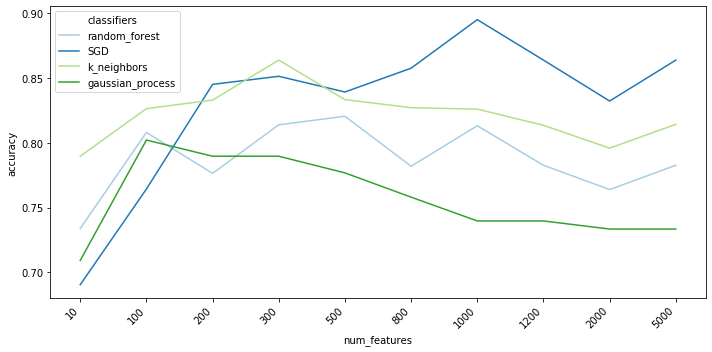

In [12]:
plt.figure(figsize=(10,5))
dt_1 = df_1.melt('num_features', var_name='classifiers', value_name='accuracy')
g = sns.lineplot(x='num_features',y='accuracy',hue='classifiers',data=dt_1, sort=False, palette='Paired')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize=10
)
plt.tight_layout()
plt.savefig('images/KFold/1.1_exp4.png')

#### 1.2 Modify just the parameter min_df
min_df is used for removing terms that appear too infrequently.

##### 1.2.1  Number of documents
- min_df = 5 means "ignore terms that appear in less than 5 documents".
- The default min_df is 1, which means "ignore terms that appear in less than 1 document". Thus, the default setting does not ignore any terms.

In [13]:
data = {}

df_min = [1,10,20,30,40,50,60,70,80,90,100,110,120,130,140]

#Step 1: set experiment configuration as dataframe index
for num in df_min:
    #Add configuration to data_frame
    column_name = str(num)
    if not 'df_min_int' in data:
        data['df_min_int'] = []
    data['df_min_int'].append(column_name)
    
    
#Step 2: find data
for name_classifier in classifiers:    
    print(data)
    print ('----------------------------------')
    print ('Classifier: ' + name_classifier)
    classifier = classifiers[name_classifier]()
    
        
    for num in df_min:
        
        tfidfconverter = TfidfVectorizer(min_df=num, stop_words=stopwords.words('english'))
        x = tfidfconverter.fit_transform(documents).toarray()
        
        scores = cross_val_score(classifier,x,y,cv=10)
            
        print(num)
        print(scores)
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        
        #Add data to column
        if not name_classifier in data:
            data[name_classifier] = []
        data[name_classifier].append(scores.mean())
                      
df_2 = pd.DataFrame(data)
print(df_2)

{'df_min_int': ['1', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100', '110', '120', '130', '140']}
----------------------------------
Classifier: random_forest
1
[0.94117647 0.88235294 0.875      0.75       0.75       0.8125
 0.8125     0.6875     0.6875     0.6875    ]
Accuracy: 0.79 (+/- 0.17)
10
[0.94117647 0.94117647 0.8125     0.8125     0.75       0.75
 0.8125     0.875      0.8125     0.6875    ]
Accuracy: 0.82 (+/- 0.15)
20
[0.94117647 0.88235294 0.8125     0.8125     0.75       0.6875
 0.8125     0.875      0.75       0.6875    ]
Accuracy: 0.80 (+/- 0.16)
30
[0.94117647 0.82352941 0.8125     0.8125     0.875      0.875
 0.8125     0.8125     0.75       0.6875    ]
Accuracy: 0.82 (+/- 0.13)
40
[0.94117647 0.76470588 0.8125     0.8125     0.75       0.6875
 0.8125     0.875      0.8125     0.75      ]
Accuracy: 0.80 (+/- 0.13)
50
[0.94117647 0.64705882 0.8125     0.8125     0.8125     0.75
 0.8125     0.875      0.8125     0.6875    ]
Accuracy: 0.80 (+/- 0.16)
60
[0.

1
[0.88235294 0.76470588 0.8125     0.6875     0.6875     0.6875
 0.75       0.6875     0.6875     0.6875    ]
Accuracy: 0.73 (+/- 0.13)
10
[0.88235294 0.82352941 0.8125     0.8125     0.8125     0.6875
 0.8125     0.6875     0.8125     0.6875    ]
Accuracy: 0.78 (+/- 0.13)
20
[0.88235294 0.82352941 0.75       0.8125     0.8125     0.6875
 0.8125     0.6875     0.8125     0.6875    ]
Accuracy: 0.78 (+/- 0.13)
30
[0.88235294 0.82352941 0.75       0.8125     0.8125     0.6875
 0.8125     0.8125     0.8125     0.6875    ]
Accuracy: 0.79 (+/- 0.12)
40
[0.88235294 0.76470588 0.75       0.8125     0.8125     0.625
 0.8125     0.8125     0.8125     0.75      ]
Accuracy: 0.78 (+/- 0.13)
50
[0.88235294 0.76470588 0.75       0.875      0.8125     0.625
 0.8125     0.875      0.8125     0.75      ]
Accuracy: 0.80 (+/- 0.15)
60
[0.88235294 0.76470588 0.75       0.8125     0.8125     0.6875
 0.8125     0.75       0.8125     0.75      ]
Accuracy: 0.78 (+/- 0.10)
70
[0.88235294 0.76470588 0.75       

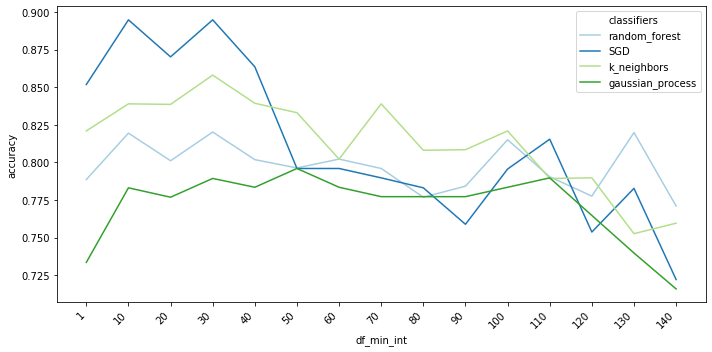

In [14]:
plt.figure(figsize=(10,5))
dt_2 = df_2.melt('df_min_int', var_name='classifiers', value_name='accuracy')
g = sns.lineplot(x='df_min_int',y='accuracy',hue='classifiers',data=dt_2, sort=False, palette='Paired')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize=10
)
plt.tight_layout()
plt.savefig('images/KFold/1.2.1_exp4.png')

##### 1.2.2 Percentage of documents
- min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".

In [16]:
data = {}

df_min = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

#Step 1: set experiment configuration as dataframe index
for num in df_min:
    #Add configuration to data_frame
    column_name = str(num)
    if not 'df_min_dec' in data:
        data['df_min_dec'] = []
    data['df_min_dec'].append(column_name)
    
#Step 2: find data
for name_classifier in classifiers:    
    print(data)
    print ('----------------------------------')
    print ('Classifier: ' + name_classifier)
    classifier = classifiers[name_classifier]()
    
        
    for num in df_min:
        
        tfidfconverter = TfidfVectorizer(min_df=num, stop_words=stopwords.words('english'))
        x = tfidfconverter.fit_transform(documents).toarray()
        
        scores = cross_val_score(classifier,x,y,cv=10)
            
        print(num)
        print(scores)
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        
        #Add data to column
        if not name_classifier in data:
            data[name_classifier] = []
        data[name_classifier].append(scores.mean())
                      
df_3 = pd.DataFrame(data)
print(df_3)

{'df_min_dec': ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9']}
----------------------------------
Classifier: random_forest
0.1
[0.94117647 0.82352941 0.875      0.75       0.6875     0.6875
 0.8125     0.75       0.75       0.75      ]
Accuracy: 0.78 (+/- 0.15)
0.2
[0.88235294 0.82352941 0.75       0.75       0.8125     0.6875
 0.875      0.8125     0.625      0.6875    ]
Accuracy: 0.77 (+/- 0.16)
0.3
[0.94117647 0.76470588 0.8125     0.75       0.75       0.75
 0.875      0.875      0.8125     0.6875    ]
Accuracy: 0.80 (+/- 0.15)
0.4
[0.94117647 0.70588235 0.75       0.8125     0.75       0.6875
 0.875      0.875      0.6875     0.75      ]
Accuracy: 0.78 (+/- 0.17)
0.5
[0.94117647 0.70588235 0.75       0.75       0.75       0.75
 0.8125     0.9375     0.6875     0.6875    ]
Accuracy: 0.78 (+/- 0.18)
0.6
[0.88235294 0.70588235 0.75       0.75       0.8125     0.75
 0.875      0.9375     0.75       0.625     ]
Accuracy: 0.78 (+/- 0.18)
0.7
[0.88235294 0.70588235 0.75

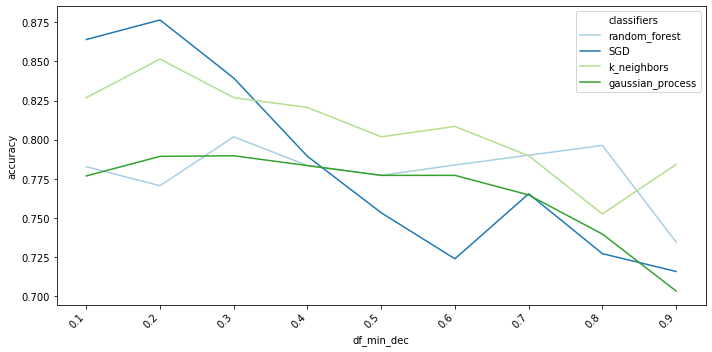

In [17]:
plt.figure(figsize=(10,5))
dt_3 = df_3.melt('df_min_dec', var_name='classifiers', value_name='accuracy')
g = sns.lineplot(x='df_min_dec',y='accuracy',hue='classifiers',data=dt_3, sort=False, palette='Paired')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize=10
)
plt.tight_layout() 
plt.savefig('images/KFold/1.2.2_exp4.png')

#### 1.3 Modify just the parameter max_df
max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words.

##### 1.3.1  Number of documents
- max_df = 25 means "ignore terms that appear in more than 25 documents".

In [18]:
data = {}

df_max = [1,10,20,30,40,50,60,70,80,90,100,110,120,130,140]

#Step 1: set experiment configuration as dataframe index
for num in df_max:
    #Add configuration to data_frame
    column_name = str(num)
    if not 'df_max_int' in data:
        data['df_max_int'] = []
    data['df_max_int'].append(column_name)
    
#Step 2: find data
for name_classifier in classifiers:    
    print(data)
    print ('----------------------------------')
    print ('Classifier: ' + name_classifier)
    classifier = classifiers[name_classifier]()
    
        
    for num in df_max:
        
        tfidfconverter = TfidfVectorizer(max_df=num, stop_words=stopwords.words('english'))
        x = tfidfconverter.fit_transform(documents).toarray()
        
        scores = cross_val_score(classifier,x,y,cv=10)
            
        print(num)
        print(scores)
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        
        #Add data to column
        if not name_classifier in data:
            data[name_classifier] = []
        data[name_classifier].append(scores.mean())
        
df_4 = pd.DataFrame(data)
print(df_4)

{'df_max_int': ['1', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100', '110', '120', '130', '140']}
----------------------------------
Classifier: random_forest
1
[0.35294118 0.35294118 0.375      0.375      0.375      0.375
 0.375      0.375      0.375      0.375     ]
Accuracy: 0.37 (+/- 0.02)
10
[0.94117647 0.76470588 0.8125     0.6875     0.6875     0.75
 0.75       0.6875     0.6875     0.6875    ]
Accuracy: 0.75 (+/- 0.15)
20
[1.         0.82352941 0.8125     0.6875     0.6875     0.6875
 0.75       0.6875     0.75       0.75      ]
Accuracy: 0.76 (+/- 0.19)
30
[0.94117647 0.76470588 0.8125     0.6875     0.6875     0.6875
 0.6875     0.6875     0.6875     0.75      ]
Accuracy: 0.74 (+/- 0.16)
40
[0.88235294 0.82352941 0.8125     0.6875     0.5        0.75
 0.8125     0.6875     0.6875     0.75      ]
Accuracy: 0.74 (+/- 0.20)
50
[0.94117647 0.82352941 0.75       0.75       0.625      0.75
 0.8125     0.6875     0.6875     0.6875    ]
Accuracy: 0.75 (+/- 0.17)
60
[0.94

1
[0.64705882 0.64705882 0.625      0.625      0.625      0.625
 0.625      0.625      0.625      0.625     ]
Accuracy: 0.63 (+/- 0.02)
10
[0.88235294 0.76470588 0.75       0.6875     0.625      0.625
 0.75       0.625      0.6875     0.625     ]
Accuracy: 0.70 (+/- 0.16)
20
[0.88235294 0.76470588 0.75       0.6875     0.625      0.625
 0.75       0.625      0.6875     0.625     ]
Accuracy: 0.70 (+/- 0.16)
30
[0.88235294 0.76470588 0.75       0.6875     0.625      0.625
 0.75       0.625      0.6875     0.625     ]
Accuracy: 0.70 (+/- 0.16)
40
[0.88235294 0.76470588 0.75       0.6875     0.625      0.625
 0.75       0.625      0.6875     0.625     ]
Accuracy: 0.70 (+/- 0.16)
50
[0.88235294 0.76470588 0.75       0.6875     0.625      0.625
 0.75       0.625      0.6875     0.625     ]
Accuracy: 0.70 (+/- 0.16)
60
[0.88235294 0.76470588 0.75       0.6875     0.625      0.625
 0.75       0.625      0.6875     0.625     ]
Accuracy: 0.70 (+/- 0.16)
70
[0.88235294 0.76470588 0.75       0.687

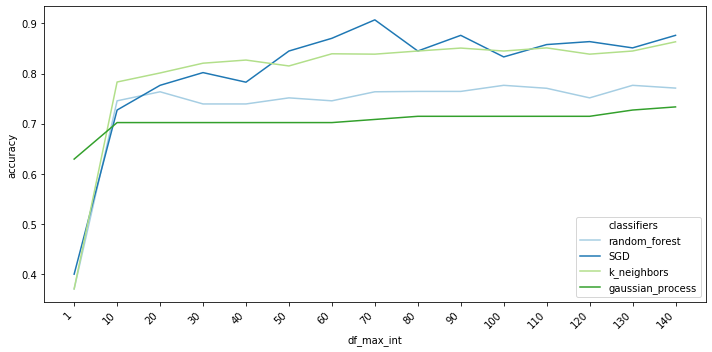

In [19]:
plt.figure(figsize=(10,5))
dt_4 = df_4.melt('df_max_int', var_name='classifiers', value_name='accuracy')
g = sns.lineplot(x='df_max_int',y='accuracy',hue='classifiers',data=dt_4, sort=False, palette='Paired')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize=10
)
plt.tight_layout() 
plt.savefig('images/KFold/1.3.1_exp4.png')

##### 1.3.2 Percentage of documents
- max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".
- The default max_df is 1.0, which means "ignore terms that appear in more than 100% of the documents". Thus, the default setting does not ignore any terms.

In [20]:
data = {}

df_max = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

#Step 1: set experiment configuration as dataframe index
for num in df_max:
    #Add configuration to data_frame
    column_name = str(num)
    if not 'df_max_dec' in data:
        data['df_max_dec'] = []
    data['df_max_dec'].append(column_name)

#Step 2: find data
for name_classifier in classifiers:    
    print(data)
    print ('----------------------------------')
    print ('Classifier: ' + name_classifier)
    classifier = classifiers[name_classifier]()
    
        
    for num in df_max:
        
        tfidfconverter = TfidfVectorizer(max_df=num, stop_words=stopwords.words('english'))
        x = tfidfconverter.fit_transform(documents).toarray()
        
        scores = cross_val_score(classifier,x,y,cv=10)
            
        print(num)
        print(scores)
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        
        #Add data to column
        if not name_classifier in data:
            data[name_classifier] = []
        data[name_classifier].append(scores.mean())
        
df_5 = pd.DataFrame(data)
print(df_5)

{'df_max_dec': ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9']}
----------------------------------
Classifier: random_forest
0.1
[0.94117647 0.76470588 0.8125     0.6875     0.6875     0.6875
 0.75       0.6875     0.6875     0.625     ]
Accuracy: 0.73 (+/- 0.17)
0.2
[0.94117647 0.76470588 0.8125     0.6875     0.6875     0.75
 0.6875     0.75       0.75       0.75      ]
Accuracy: 0.76 (+/- 0.14)
0.3
[0.94117647 0.76470588 0.8125     0.6875     0.625      0.8125
 0.8125     0.6875     0.6875     0.6875    ]
Accuracy: 0.75 (+/- 0.18)
0.4
[0.94117647 0.76470588 0.8125     0.6875     0.75       0.75
 0.75       0.6875     0.6875     0.6875    ]
Accuracy: 0.75 (+/- 0.15)
0.5
[0.94117647 0.82352941 0.8125     0.6875     0.6875     0.8125
 0.75       0.75       0.75       0.6875    ]
Accuracy: 0.77 (+/- 0.15)
0.6
[0.88235294 0.82352941 0.875      0.6875     0.6875     0.8125
 0.8125     0.75       0.75       0.6875    ]
Accuracy: 0.78 (+/- 0.14)
0.7
[0.88235294 0.88235294 0.

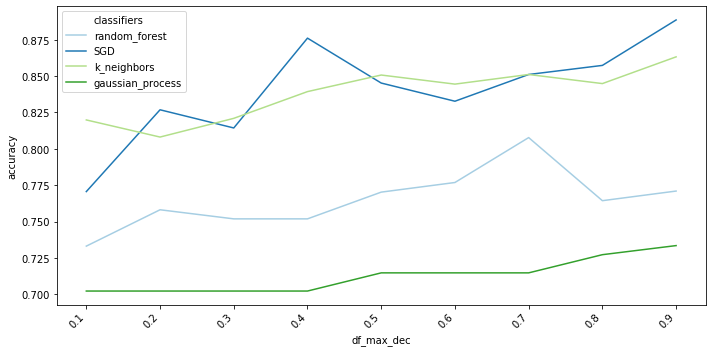

In [21]:
plt.figure(figsize=(10,5))
dt_5 = df_5.melt('df_max_dec', var_name='classifiers', value_name='accuracy')
g = sns.lineplot(x='df_max_dec',y='accuracy',hue='classifiers',data=dt_5, sort=False, palette='Paired')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize=10
)
plt.tight_layout() 
plt.savefig('images/KFold/1.3.2_exp4.png')

### Experiment 2. Combine multiple parameters with the default configuration of each classifier

### 2.1 Modify the parameter max_features, number of documents(integers) in min_df and number of documents in max_df

In [23]:
data = {}

classifiers = {
    'SGD': SGDClassifier,
    'k_neighbors': KNeighborsClassifier}

features = [10,100,200,300,500,800,1000,1200,2000,5000]
df = [1,10,20,30,40,50,60,70,80,90,100,110,120,130,140]

#Step 1: set experiment configuration as dataframe index
for num in features:
    for min_df in df:
        for max_df in df:
            #Add configuration to data_frame
            column_name = 'f_'+str(num)+'_min_'+str(min_df)+'_max_'+str(max_df)
            if not 'configuration' in data:
                data['configuration'] = []
            data['configuration'].append(column_name)
            
#Step 2: find data
for name_classifier in classifiers:    
    print(data)
    print ('----------------------------------')
    print ('Classifier: ' + name_classifier)
    classifier = classifiers[name_classifier]()
    
    for num in features:
        for min_df in df:
            for max_df in df:
                
                try:
                    tfidfconverter = TfidfVectorizer(max_features=num, min_df=min_df, max_df=max_df, stop_words=stopwords.words('english'))
                    x = tfidfconverter.fit_transform(documents).toarray()

                    scores = cross_val_score(classifier,x,y,cv=10)

                    print('f_'+str(num)+'_min_'+str(min_df)+'_max_'+str(max_df))
                    print(scores)
                    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
                    
                    accuracy = scores.mean()
                    
                except Exception:
                    print('There was an error')
                    accuracy = 0
                    
                #Add data to column
                if not name_classifier in data:
                    data[name_classifier] = []
                data[name_classifier].append(accuracy)
                
df_6 = pd.DataFrame(data)
print(df_6)

{'configuration': ['f_10_min_1_max_1', 'f_10_min_1_max_10', 'f_10_min_1_max_20', 'f_10_min_1_max_30', 'f_10_min_1_max_40', 'f_10_min_1_max_50', 'f_10_min_1_max_60', 'f_10_min_1_max_70', 'f_10_min_1_max_80', 'f_10_min_1_max_90', 'f_10_min_1_max_100', 'f_10_min_1_max_110', 'f_10_min_1_max_120', 'f_10_min_1_max_130', 'f_10_min_1_max_140', 'f_10_min_10_max_1', 'f_10_min_10_max_10', 'f_10_min_10_max_20', 'f_10_min_10_max_30', 'f_10_min_10_max_40', 'f_10_min_10_max_50', 'f_10_min_10_max_60', 'f_10_min_10_max_70', 'f_10_min_10_max_80', 'f_10_min_10_max_90', 'f_10_min_10_max_100', 'f_10_min_10_max_110', 'f_10_min_10_max_120', 'f_10_min_10_max_130', 'f_10_min_10_max_140', 'f_10_min_20_max_1', 'f_10_min_20_max_10', 'f_10_min_20_max_20', 'f_10_min_20_max_30', 'f_10_min_20_max_40', 'f_10_min_20_max_50', 'f_10_min_20_max_60', 'f_10_min_20_max_70', 'f_10_min_20_max_80', 'f_10_min_20_max_90', 'f_10_min_20_max_100', 'f_10_min_20_max_110', 'f_10_min_20_max_120', 'f_10_min_20_max_130', 'f_10_min_20_max_

f_10_min_1_max_1
[0.35294118 0.64705882 0.375      0.625      0.625      0.625
 0.625      0.375      0.625      0.625     ]
Accuracy: 0.55 (+/- 0.24)
f_10_min_1_max_10
[0.64705882 0.47058824 0.625      0.375      0.625      0.625
 0.5625     0.5625     0.375      0.625     ]
Accuracy: 0.55 (+/- 0.20)
f_10_min_1_max_20
[0.64705882 0.64705882 0.625      0.5        0.625      0.625
 0.625      0.5625     0.5625     0.625     ]
Accuracy: 0.60 (+/- 0.09)
f_10_min_1_max_30
[0.58823529 0.64705882 0.4375     0.625      0.625      0.625
 0.375      0.375      0.4375     0.625     ]
Accuracy: 0.54 (+/- 0.22)
f_10_min_1_max_40
[0.70588235 0.70588235 0.625      0.625      0.625      0.5
 0.5        0.75       0.75       0.6875    ]
Accuracy: 0.65 (+/- 0.17)
f_10_min_1_max_50
[0.76470588 0.64705882 0.5        0.5625     0.5625     0.6875
 0.625      0.625      0.625      0.75      ]
Accuracy: 0.63 (+/- 0.16)
f_10_min_1_max_60
[0.76470588 0.64705882 0.5625     0.8125     0.625      0.75
 0.5625    

f_10_min_30_max_140
[0.47058824 0.70588235 0.625      0.75       0.6875     0.6875
 0.4375     0.5625     0.4375     0.8125    ]
Accuracy: 0.62 (+/- 0.26)
There was an error
There was an error
There was an error
There was an error
f_10_min_40_max_40
[0.41176471 0.64705882 0.5        0.625      0.6875     0.625
 0.625      0.8125     0.625      0.6875    ]
Accuracy: 0.62 (+/- 0.20)
f_10_min_40_max_50
[0.70588235 0.52941176 0.5        0.625      0.6875     0.5
 0.75       0.625      0.625      0.625     ]
Accuracy: 0.62 (+/- 0.16)
f_10_min_40_max_60
[0.88235294 0.58823529 0.5625     0.8125     0.5625     0.75
 0.625      0.75       0.8125     0.5625    ]
Accuracy: 0.69 (+/- 0.23)
f_10_min_40_max_70
[0.82352941 0.82352941 0.875      0.8125     0.75       0.5
 0.6875     0.625      0.5        0.625     ]
Accuracy: 0.70 (+/- 0.26)
f_10_min_40_max_80
[0.76470588 0.64705882 0.6875     0.5625     0.4375     0.8125
 0.625      0.75       0.5625     0.625     ]
Accuracy: 0.65 (+/- 0.21)
f_10_min

f_10_min_90_max_120
[0.82352941 0.70588235 0.75       0.5625     0.6875     0.5
 0.625      0.6875     0.8125     0.6875    ]
Accuracy: 0.68 (+/- 0.19)
f_10_min_90_max_130
[0.58823529 0.52941176 0.6875     0.625      0.8125     0.6875
 0.8125     0.75       0.75       0.75      ]
Accuracy: 0.70 (+/- 0.18)
f_10_min_90_max_140
[0.64705882 0.76470588 0.6875     0.75       0.75       0.75
 0.5        0.625      0.4375     0.875     ]
Accuracy: 0.68 (+/- 0.25)
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_10_min_100_max_100
[0.58823529 0.52941176 0.6875     0.625      0.4375     0.6875
 0.625      0.5        0.625      0.625     ]
Accuracy: 0.59 (+/- 0.15)
f_10_min_100_max_110
[0.88235294 0.64705882 0.6875     0.5625     0.5625     0.3125
 0.4375     0.75       0.625      0.6875    ]
Accuracy: 0.62 (+/- 0.30)
f_10_min_100_max_120
[0.64705882 0.470

f_100_min_20_max_30
[0.82352941 0.64705882 0.875      0.75       0.8125     0.6875
 0.5625     0.75       0.8125     0.6875    ]
Accuracy: 0.74 (+/- 0.18)
f_100_min_20_max_40
[0.94117647 0.76470588 0.9375     0.6875     0.875      0.75
 0.625      0.8125     0.625      0.75      ]
Accuracy: 0.78 (+/- 0.22)
f_100_min_20_max_50
[0.82352941 0.70588235 0.8125     0.625      0.8125     0.875
 0.75       0.8125     0.8125     0.875     ]
Accuracy: 0.79 (+/- 0.15)
f_100_min_20_max_60
[0.88235294 0.88235294 0.75       0.9375     0.9375     0.9375
 0.8125     0.875      0.8125     0.9375    ]
Accuracy: 0.88 (+/- 0.13)
f_100_min_20_max_70
[0.88235294 0.76470588 0.9375     0.8125     0.875      0.8125
 0.8125     0.875      0.875      0.875     ]
Accuracy: 0.85 (+/- 0.10)
f_100_min_20_max_80
[0.88235294 0.82352941 0.8125     0.75       0.75       0.8125
 0.75       0.6875     0.5625     0.9375    ]
Accuracy: 0.78 (+/- 0.20)
f_100_min_20_max_90
[0.82352941 0.94117647 0.75       0.75       0.8125  

f_100_min_60_max_120
[0.88235294 0.52941176 0.625      0.75       0.8125     0.6875
 0.75       0.6875     0.625      0.6875    ]
Accuracy: 0.70 (+/- 0.19)
f_100_min_60_max_130
[0.94117647 0.70588235 0.625      0.75       0.875      0.75
 0.8125     0.75       0.75       0.6875    ]
Accuracy: 0.76 (+/- 0.17)
f_100_min_60_max_140
[0.88235294 0.70588235 0.6875     0.875      0.8125     0.6875
 0.875      0.8125     0.6875     0.875     ]
Accuracy: 0.79 (+/- 0.17)
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_100_min_70_max_70
[0.70588235 0.64705882 0.625      0.6875     0.625      0.625
 0.6875     0.5        0.5        0.8125    ]
Accuracy: 0.64 (+/- 0.18)
f_100_min_70_max_80
[0.82352941 0.47058824 0.625      0.75       0.75       0.6875
 0.75       0.875      0.5625     0.6875    ]
Accuracy: 0.70 (+/- 0.23)
f_100_min_70_max_90
[0.58823529 0.82352941 0.5625     0.75       0.8125     0.8125
 0.8125  

f_200_min_1_max_60
[0.88235294 0.94117647 0.875      0.875      0.875      0.875
 0.75       0.8125     0.9375     0.875     ]
Accuracy: 0.87 (+/- 0.11)
f_200_min_1_max_70
[0.88235294 0.82352941 0.8125     0.875      0.875      0.9375
 0.8125     0.9375     0.9375     0.875     ]
Accuracy: 0.88 (+/- 0.09)
f_200_min_1_max_80
[0.88235294 0.76470588 0.875      0.875      0.9375     0.9375
 0.8125     0.9375     0.875      0.875     ]
Accuracy: 0.88 (+/- 0.11)
f_200_min_1_max_90
[0.88235294 0.94117647 0.75       0.8125     0.9375     0.8125
 0.8125     0.8125     0.875      0.75      ]
Accuracy: 0.84 (+/- 0.13)
f_200_min_1_max_100
[0.82352941 0.82352941 0.875      0.875      0.8125     0.875
 0.75       0.75       0.9375     0.75      ]
Accuracy: 0.83 (+/- 0.12)
f_200_min_1_max_110
[0.94117647 0.70588235 0.75       0.875      0.75       0.8125
 0.8125     0.875      0.8125     0.8125    ]
Accuracy: 0.81 (+/- 0.13)
f_200_min_1_max_120
[0.88235294 0.82352941 0.6875     0.8125     0.6875     

f_200_min_40_max_80
[0.88235294 0.82352941 0.8125     0.875      0.9375     0.875
 0.8125     0.875      0.9375     0.8125    ]
Accuracy: 0.86 (+/- 0.09)
f_200_min_40_max_90
[0.88235294 0.88235294 0.875      0.875      0.9375     0.875
 0.875      0.75       0.875      0.8125    ]
Accuracy: 0.86 (+/- 0.09)
f_200_min_40_max_100
[0.94117647 0.82352941 0.8125     0.875      0.875      0.8125
 0.8125     0.8125     0.8125     0.8125    ]
Accuracy: 0.84 (+/- 0.08)
f_200_min_40_max_110
[0.88235294 0.82352941 0.6875     0.8125     0.75       0.8125
 0.75       0.75       0.75       0.875     ]
Accuracy: 0.79 (+/- 0.12)
f_200_min_40_max_120
[0.94117647 0.76470588 0.6875     0.8125     0.75       0.8125
 0.8125     0.9375     0.8125     0.8125    ]
Accuracy: 0.81 (+/- 0.15)
f_200_min_40_max_130
[0.94117647 0.70588235 0.625      0.875      0.8125     0.75
 0.9375     0.8125     0.8125     0.75      ]
Accuracy: 0.80 (+/- 0.19)
f_200_min_40_max_140
[0.94117647 0.70588235 0.6875     0.875      0.75

f_200_min_100_max_110
[0.88235294 0.70588235 0.6875     0.5        0.5625     0.5625
 0.625      0.6875     0.8125     0.625     ]
Accuracy: 0.67 (+/- 0.22)
f_200_min_100_max_120
[0.82352941 0.64705882 0.5        0.6875     0.625      0.6875
 0.625      0.6875     0.875      0.625     ]
Accuracy: 0.68 (+/- 0.20)
f_200_min_100_max_130
[0.82352941 0.70588235 0.625      0.8125     0.625      0.6875
 0.8125     0.9375     0.6875     0.8125    ]
Accuracy: 0.75 (+/- 0.19)
f_200_min_100_max_140
[0.94117647 0.76470588 0.75       0.8125     0.8125     0.6875
 0.6875     0.8125     0.8125     0.875     ]
Accuracy: 0.80 (+/- 0.15)
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_200_min_110_max_110
[0.64705882 0.58823529 0.6875     0.625      0.625      0.625
 0.625      0.4375     0.625      0.625     ]
Accuracy: 0.61 (+/- 0.12)
f_200_m

f_300_min_20_max_80
[0.88235294 0.70588235 0.9375     0.8125     0.9375     0.875
 0.875      0.875      0.875      0.8125    ]
Accuracy: 0.86 (+/- 0.13)
f_300_min_20_max_90
[0.94117647 0.76470588 0.9375     0.875      0.875      0.8125
 0.875      0.9375     0.875      0.9375    ]
Accuracy: 0.88 (+/- 0.11)
f_300_min_20_max_100
[0.94117647 0.76470588 0.9375     0.8125     0.75       0.875
 0.875      0.875      0.875      0.8125    ]
Accuracy: 0.85 (+/- 0.12)
f_300_min_20_max_110
[0.88235294 0.88235294 0.875      0.8125     0.875      0.875
 0.8125     0.75       0.6875     0.75      ]
Accuracy: 0.82 (+/- 0.13)
f_300_min_20_max_120
[0.88235294 0.82352941 0.875      0.875      0.875      0.875
 0.875      0.75       0.875      0.875     ]
Accuracy: 0.86 (+/- 0.08)
f_300_min_20_max_130
[0.94117647 0.76470588 0.8125     0.8125     0.6875     0.8125
 0.9375     0.8125     0.875      0.8125    ]
Accuracy: 0.83 (+/- 0.14)
f_300_min_20_max_140
[0.94117647 0.88235294 0.8125     0.875      0.81

f_300_min_70_max_80
[0.82352941 0.58823529 0.625      0.8125     0.8125     0.75
 0.75       0.875      0.6875     0.6875    ]
Accuracy: 0.74 (+/- 0.18)
f_300_min_70_max_90
[0.88235294 0.76470588 0.6875     0.75       0.8125     0.8125
 0.6875     0.875      0.5625     0.6875    ]
Accuracy: 0.75 (+/- 0.19)
f_300_min_70_max_100
[0.70588235 0.76470588 0.625      0.6875     0.875      0.75
 0.6875     0.9375     0.5625     0.5625    ]
Accuracy: 0.72 (+/- 0.23)
f_300_min_70_max_110
[0.76470588 0.76470588 0.625      0.75       0.8125     0.5
 0.75       0.9375     0.5        0.625     ]
Accuracy: 0.70 (+/- 0.26)
f_300_min_70_max_120
[0.82352941 0.58823529 0.5625     0.75       0.75       0.75
 0.875      0.875      0.625      0.75      ]
Accuracy: 0.73 (+/- 0.21)
f_300_min_70_max_130
[0.76470588 0.70588235 0.625      0.75       0.8125     0.5625
 0.875      0.875      0.75       0.75      ]
Accuracy: 0.75 (+/- 0.19)
f_300_min_70_max_140
[0.94117647 0.70588235 0.6875     0.8125     0.8125   

f_500_min_1_max_110
[0.94117647 0.76470588 0.9375     0.8125     0.8125     0.9375
 0.8125     0.875      0.9375     0.875     ]
Accuracy: 0.87 (+/- 0.13)
f_500_min_1_max_120
[0.94117647 0.76470588 0.875      0.8125     0.875      0.9375
 0.8125     0.875      0.9375     0.875     ]
Accuracy: 0.87 (+/- 0.11)
f_500_min_1_max_130
[0.94117647 0.76470588 0.8125     0.8125     0.8125     0.875
 0.9375     0.875      0.8125     0.875     ]
Accuracy: 0.85 (+/- 0.11)
f_500_min_1_max_140
[0.94117647 0.82352941 0.875      0.875      0.8125     0.875
 0.8125     0.9375     0.875      0.6875    ]
Accuracy: 0.85 (+/- 0.14)
There was an error
f_500_min_10_max_10
[0.94117647 0.64705882 0.6875     0.75       0.625      0.75
 0.625      0.8125     0.875      0.75      ]
Accuracy: 0.75 (+/- 0.20)
f_500_min_10_max_20
[0.88235294 0.94117647 0.6875     0.6875     0.8125     0.9375
 0.75       0.875      0.875      0.6875    ]
Accuracy: 0.81 (+/- 0.20)
f_500_min_10_max_30
[0.88235294 0.76470588 0.8125     0

f_500_min_40_max_130
[0.94117647 0.76470588 0.8125     0.875      0.8125     0.75
 0.9375     0.9375     0.75       0.875     ]
Accuracy: 0.85 (+/- 0.15)
f_500_min_40_max_140
[0.88235294 0.82352941 0.6875     0.875      0.8125     0.8125
 0.8125     0.875      0.9375     0.875     ]
Accuracy: 0.84 (+/- 0.13)
There was an error
There was an error
There was an error
There was an error
There was an error
f_500_min_50_max_50
[0.88235294 0.52941176 0.625      0.75       0.5625     0.625
 0.6875     0.75       0.625      0.6875    ]
Accuracy: 0.67 (+/- 0.20)
f_500_min_50_max_60
[0.88235294 0.76470588 0.8125     0.8125     0.6875     0.75
 0.8125     0.8125     0.875      0.6875    ]
Accuracy: 0.79 (+/- 0.13)
f_500_min_50_max_70
[0.88235294 0.76470588 0.8125     0.875      0.875      0.75
 0.75       0.875      0.9375     0.8125    ]
Accuracy: 0.83 (+/- 0.12)
f_500_min_50_max_80
[0.88235294 0.76470588 0.75       0.875      0.875      0.75
 0.75       0.8125     0.8125     0.75      ]
Accuracy

There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_500_min_110_max_110
[0.35294118 0.64705882 0.4375     0.375      0.625      0.625
 0.625      0.625      0.625      0.5       ]
Accuracy: 0.54 (+/- 0.22)
f_500_min_110_max_120
[0.82352941 0.58823529 0.75       0.6875     0.5        0.6875
 0.875      0.8125     0.75       0.5625    ]
Accuracy: 0.70 (+/- 0.23)
f_500_min_110_max_130
[0.82352941 0.64705882 0.8125     0.75       0.625      0.6875
 0.625      0.875      0.8125     0.75      ]
Accuracy: 0.74 (+/- 0.17)
f_500_min_110_max_140
[0.82352941 0.82352941 0.625      1.         0.6875     0.75
 0.8125     0.9375     0.75       0.8125    ]
Accuracy: 0.80 (+/- 0.21)
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an e

f_800_min_20_max_120
[0.94117647 0.82352941 0.875      0.875      0.75       0.8125
 0.75       0.8125     0.75       0.75      ]
Accuracy: 0.81 (+/- 0.13)
f_800_min_20_max_130
[0.88235294 0.88235294 0.8125     0.875      0.8125     0.8125
 0.9375     0.875      0.8125     0.875     ]
Accuracy: 0.86 (+/- 0.08)
f_800_min_20_max_140
[0.94117647 0.82352941 0.8125     0.9375     0.75       0.875
 0.8125     0.9375     0.875      0.75      ]
Accuracy: 0.85 (+/- 0.14)
There was an error
There was an error
There was an error
f_800_min_30_max_30
[0.82352941 0.76470588 0.6875     0.8125     0.75       0.5
 0.5        0.6875     0.5625     0.75      ]
Accuracy: 0.68 (+/- 0.23)
f_800_min_30_max_40
[0.88235294 0.70588235 0.9375     0.75       0.75       0.8125
 0.75       0.875      0.6875     0.6875    ]
Accuracy: 0.78 (+/- 0.17)
f_800_min_30_max_50
[0.94117647 0.70588235 0.875      0.6875     0.875      0.9375
 0.8125     0.8125     0.8125     0.9375    ]
Accuracy: 0.84 (+/- 0.17)
f_800_min_30_m

f_800_min_70_max_120
[0.70588235 0.52941176 0.625      0.75       0.6875     0.5625
 0.875      0.875      0.6875     0.75      ]
Accuracy: 0.70 (+/- 0.22)
f_800_min_70_max_130
[0.88235294 0.70588235 0.5625     0.75       0.8125     0.6875
 0.875      0.875      0.75       0.8125    ]
Accuracy: 0.77 (+/- 0.19)
f_800_min_70_max_140
[0.82352941 0.76470588 0.6875     0.8125     0.8125     0.8125
 0.875      0.875      0.75       0.8125    ]
Accuracy: 0.80 (+/- 0.11)
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_800_min_80_max_80
[0.47058824 0.64705882 0.625      0.625      0.625      0.625
 0.4375     0.625      0.625      0.625     ]
Accuracy: 0.59 (+/- 0.14)
f_800_min_80_max_90
[0.88235294 0.70588235 0.4375     0.75       0.875      0.8125
 0.6875     0.75       0.5625     0.6875    ]
Accuracy: 0.72 (+/- 0.26)
f_800_min_80_max_100
[0.64705882 0.76470588 0.75       0.6875     0.812

There was an error
f_1000_min_10_max_10
[0.88235294 0.64705882 0.5625     0.6875     0.6875     0.6875
 0.625      0.875      0.75       0.75      ]
Accuracy: 0.72 (+/- 0.19)
f_1000_min_10_max_20
[1.         0.82352941 0.875      0.625      0.6875     0.6875
 0.75       0.9375     0.8125     0.75      ]
Accuracy: 0.79 (+/- 0.22)
f_1000_min_10_max_30
[0.88235294 0.82352941 0.875      0.75       0.6875     0.875
 0.6875     0.9375     0.875      0.8125    ]
Accuracy: 0.82 (+/- 0.16)
f_1000_min_10_max_40
[0.94117647 0.82352941 0.8125     0.75       0.875      0.875
 0.75       0.875      0.875      0.75      ]
Accuracy: 0.83 (+/- 0.13)
f_1000_min_10_max_50
[0.94117647 0.88235294 0.8125     0.8125     0.8125     0.8125
 0.75       0.9375     0.9375     0.75      ]
Accuracy: 0.84 (+/- 0.14)
f_1000_min_10_max_60
[0.88235294 0.88235294 0.875      0.875      0.75       0.875
 0.8125     0.8125     0.875      0.75      ]
Accuracy: 0.84 (+/- 0.10)
f_1000_min_10_max_70
[0.94117647 0.94117647 0.93

f_1000_min_50_max_60
[0.88235294 0.70588235 0.8125     0.8125     0.6875     0.75
 0.8125     0.8125     0.875      0.875     ]
Accuracy: 0.80 (+/- 0.13)
f_1000_min_50_max_70
[0.76470588 0.82352941 0.75       0.875      0.875      0.6875
 0.8125     0.75       0.9375     0.875     ]
Accuracy: 0.82 (+/- 0.15)
f_1000_min_50_max_80
[0.88235294 0.76470588 0.8125     0.75       0.875      0.6875
 0.75       0.8125     0.8125     0.75      ]
Accuracy: 0.79 (+/- 0.12)
f_1000_min_50_max_90
[0.82352941 0.76470588 0.75       0.8125     0.875      0.875
 0.875      0.8125     0.8125     0.8125    ]
Accuracy: 0.82 (+/- 0.08)
f_1000_min_50_max_100
[0.88235294 0.82352941 0.625      0.8125     0.9375     0.75
 0.75       0.875      0.625      0.75      ]
Accuracy: 0.78 (+/- 0.20)
f_1000_min_50_max_110
[0.82352941 0.70588235 0.75       0.75       0.8125     0.75
 0.75       0.875      0.75       0.875     ]
Accuracy: 0.78 (+/- 0.11)
f_1000_min_50_max_120
[0.88235294 0.64705882 0.625      0.75       0.

f_1000_min_110_max_140
[0.58823529 0.70588235 0.75       0.9375     0.75       0.75
 0.8125     0.8125     0.75       0.8125    ]
Accuracy: 0.77 (+/- 0.17)
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_1000_min_120_max_130
[0.88235294 0.76470588 0.875      0.9375     0.625      0.75
 0.625      0.6875     0.75       0.75      ]
Accuracy: 0.76 (+/- 0.20)
f_1000_min_120_max_140
[0.82352941 0.76470588 0.875      0.6875     0.8125     0.75
 0.75       0.75       0.75       0.875     ]
Accuracy: 0.78 (+/- 0.12)
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_1000_min_130_max_130
[0.64705882 0.7

f_1200_min_30_max_30
[0.76470588 0.70588235 0.5625     0.75       0.8125     0.5625
 0.4375     0.6875     0.5625     0.75      ]
Accuracy: 0.66 (+/- 0.23)
f_1200_min_30_max_40
[0.94117647 0.82352941 0.9375     0.6875     0.8125     0.75
 0.8125     0.875      0.625      0.6875    ]
Accuracy: 0.80 (+/- 0.20)
f_1200_min_30_max_50
[0.94117647 0.82352941 0.875      0.8125     0.75       1.
 0.8125     0.8125     0.75       0.875     ]
Accuracy: 0.85 (+/- 0.15)
f_1200_min_30_max_60
[0.88235294 0.88235294 0.9375     0.8125     0.9375     0.9375
 0.8125     0.875      0.875      0.8125    ]
Accuracy: 0.88 (+/- 0.10)
f_1200_min_30_max_70
[0.82352941 0.94117647 0.875      0.75       0.875      0.875
 0.75       0.9375     0.875      0.8125    ]
Accuracy: 0.85 (+/- 0.13)
f_1200_min_30_max_80
[0.94117647 0.64705882 0.9375     0.75       0.875      0.875
 0.8125     0.875      0.9375     0.9375    ]
Accuracy: 0.86 (+/- 0.18)
f_1200_min_30_max_90
[0.88235294 0.88235294 0.8125     0.8125     0.875 

There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_1200_min_80_max_80
[0.64705882 0.64705882 0.625      0.625      0.5        0.375
 0.375      0.375      0.625      0.625     ]
Accuracy: 0.54 (+/- 0.23)
f_1200_min_80_max_90
[0.88235294 0.70588235 0.6875     0.8125     0.875      0.6875
 0.75       0.75       0.5        0.625     ]
Accuracy: 0.73 (+/- 0.22)
f_1200_min_80_max_100
[0.82352941 0.70588235 0.625      0.75       0.875      0.6875
 0.6875     0.75       0.625      0.6875    ]
Accuracy: 0.72 (+/- 0.15)
f_1200_min_80_max_110
[0.82352941 0.58823529 0.5625     0.75       0.75       0.6875
 0.625      0.8125     0.625      0.6875    ]
Accuracy: 0.69 (+/- 0.17)
f_1200_min_80_max_120
[0.76470588 0.64705882 0.6875     0.5625     0.8125     0.8125
 0.75       0.6875     0.5        0.6875    ]
Accuracy: 0.69 (+/- 0.19)
f_1200_min_80_max_130
[0.88235294 0.70588235 0.75       0.75      

f_2000_min_10_max_30
[0.94117647 0.82352941 0.875      0.8125     0.75       0.875
 0.6875     1.         0.75       0.5625    ]
Accuracy: 0.81 (+/- 0.24)
f_2000_min_10_max_40
[0.94117647 0.82352941 0.9375     0.6875     0.8125     0.875
 0.75       0.875      0.8125     0.75      ]
Accuracy: 0.83 (+/- 0.16)
f_2000_min_10_max_50
[0.94117647 0.88235294 0.9375     0.875      0.75       0.875
 0.75       0.8125     0.875      0.75      ]
Accuracy: 0.84 (+/- 0.14)
f_2000_min_10_max_60
[0.94117647 0.47058824 0.875      0.8125     0.9375     0.9375
 0.8125     0.9375     0.9375     0.8125    ]
Accuracy: 0.85 (+/- 0.27)
f_2000_min_10_max_70
[0.88235294 0.94117647 0.875      0.8125     0.875      0.9375
 0.875      0.9375     0.9375     0.8125    ]
Accuracy: 0.89 (+/- 0.09)
f_2000_min_10_max_80
[0.94117647 0.88235294 1.         0.875      0.75       0.9375
 0.8125     1.         0.875      0.9375    ]
Accuracy: 0.90 (+/- 0.15)
f_2000_min_10_max_90
[0.88235294 0.88235294 0.8125     0.8125     0

f_2000_min_50_max_80
[0.88235294 0.70588235 0.6875     0.875      0.875      0.6875
 0.75       0.8125     0.8125     0.75      ]
Accuracy: 0.78 (+/- 0.15)
f_2000_min_50_max_90
[0.82352941 0.70588235 0.75       0.8125     0.9375     0.8125
 0.875      0.75       0.8125     0.8125    ]
Accuracy: 0.81 (+/- 0.12)
f_2000_min_50_max_100
[0.88235294 0.82352941 0.8125     0.75       0.9375     0.8125
 0.75       0.75       0.75       0.6875    ]
Accuracy: 0.80 (+/- 0.14)
f_2000_min_50_max_110
[0.88235294 0.82352941 0.75       0.8125     0.875      0.75
 0.75       0.875      0.6875     0.8125    ]
Accuracy: 0.80 (+/- 0.12)
f_2000_min_50_max_120
[0.88235294 0.64705882 0.625      0.8125     0.875      0.8125
 0.875      0.875      0.8125     0.75      ]
Accuracy: 0.80 (+/- 0.18)
f_2000_min_50_max_130
[0.88235294 0.76470588 0.6875     0.8125     0.875      0.6875
 0.9375     0.875      0.8125     0.75      ]
Accuracy: 0.81 (+/- 0.16)
f_2000_min_50_max_140
[0.94117647 0.88235294 0.6875     0.8125

There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_2000_min_120_max_130
[0.76470588 0.70588235 0.9375     0.875      0.75       0.6875
 0.6875     0.875      0.5625     0.75      ]
Accuracy: 0.76 (+/- 0.21)
f_2000_min_120_max_140
[0.88235294 0.70588235 0.6875     0.875      0.875      0.6875
 0.6875     0.75       0.6875     0.9375    ]
Accuracy: 0.78 (+/- 0.19)
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_2000_min_130_max_130
[0.76470588 0.64705882 0.6875     0.5        0.625      0.8125
 0.5625     0.8125     0.625      0.625     ]
Accuracy: 0.67 (+/- 0.20)
f_2000_min_130_max_140
[0.82352941 0.82352941 0.8125     0.6875     0.

f_5000_min_30_max_50
[0.94117647 0.82352941 0.875      0.75       0.8125     0.9375
 0.75       0.75       0.8125     0.8125    ]
Accuracy: 0.83 (+/- 0.14)
f_5000_min_30_max_60
[0.88235294 1.         0.9375     0.875      0.8125     0.9375
 0.875      1.         0.875      0.8125    ]
Accuracy: 0.90 (+/- 0.13)
f_5000_min_30_max_70
[0.94117647 0.58823529 0.9375     0.8125     0.8125     0.9375
 0.8125     0.875      0.75       0.875     ]
Accuracy: 0.83 (+/- 0.21)
f_5000_min_30_max_80
[0.88235294 0.88235294 0.9375     0.8125     0.9375     0.875
 0.8125     0.9375     0.875      0.9375    ]
Accuracy: 0.89 (+/- 0.09)
f_5000_min_30_max_90
[0.94117647 0.82352941 0.75       0.75       0.9375     0.875
 0.875      0.875      0.8125     0.75      ]
Accuracy: 0.84 (+/- 0.14)
f_5000_min_30_max_100
[0.94117647 0.82352941 0.8125     0.75       0.75       0.9375
 0.875      0.875      0.9375     0.8125    ]
Accuracy: 0.85 (+/- 0.14)
f_5000_min_30_max_110
[0.94117647 0.82352941 0.875      0.6875   

f_5000_min_80_max_90
[0.88235294 0.70588235 0.625      0.75       0.875      0.6875
 0.625      0.8125     0.5        0.6875    ]
Accuracy: 0.72 (+/- 0.23)
f_5000_min_80_max_100
[0.76470588 0.58823529 0.625      0.75       0.875      0.8125
 0.6875     0.75       0.6875     0.6875    ]
Accuracy: 0.72 (+/- 0.16)
f_5000_min_80_max_110
[0.76470588 0.52941176 0.4375     0.5625     0.75       0.6875
 0.6875     0.8125     0.5625     0.5625    ]
Accuracy: 0.64 (+/- 0.23)
f_5000_min_80_max_120
[0.88235294 0.64705882 0.625      0.6875     0.625      0.6875
 0.75       0.6875     0.625      0.5625    ]
Accuracy: 0.68 (+/- 0.17)
f_5000_min_80_max_130
[0.82352941 0.76470588 0.6875     0.8125     0.875      0.75
 0.6875     0.8125     0.6875     0.6875    ]
Accuracy: 0.76 (+/- 0.13)
f_5000_min_80_max_140
[0.82352941 0.70588235 0.5625     0.8125     0.75       0.6875
 0.625      0.875      0.6875     0.8125    ]
Accuracy: 0.73 (+/- 0.19)
There was an error
There was an error
There was an error
Ther

f_10_min_1_max_1
[0.35294118 0.64705882 0.625      0.625      0.625      0.375
 0.375      0.375      0.375      0.375     ]
Accuracy: 0.47 (+/- 0.25)
f_10_min_1_max_10
[0.41176471 0.64705882 0.625      0.625      0.625      0.4375
 0.3125     0.375      0.375      0.4375    ]
Accuracy: 0.49 (+/- 0.24)
f_10_min_1_max_20
[0.64705882 0.52941176 0.5625     0.4375     0.5        0.625
 0.5625     0.6875     0.5625     0.6875    ]
Accuracy: 0.58 (+/- 0.15)
f_10_min_1_max_30
[0.58823529 0.58823529 0.4375     0.5625     0.6875     0.6875
 0.6875     0.5625     0.6875     0.5       ]
Accuracy: 0.60 (+/- 0.17)
f_10_min_1_max_40
[0.58823529 0.70588235 0.5        0.625      0.6875     0.5625
 0.5625     0.8125     0.6875     0.75      ]
Accuracy: 0.65 (+/- 0.18)
f_10_min_1_max_50
[0.70588235 0.64705882 0.625      0.625      0.75       0.625
 0.6875     0.75       0.625      0.6875    ]
Accuracy: 0.67 (+/- 0.10)
f_10_min_1_max_60
[0.82352941 0.58823529 0.5625     0.8125     0.625      0.8125
 0.75

f_10_min_30_max_140
[0.88235294 0.76470588 0.6875     0.8125     0.6875     0.875
 0.4375     0.75       0.5625     0.8125    ]
Accuracy: 0.73 (+/- 0.27)
There was an error
There was an error
There was an error
There was an error
f_10_min_40_max_40
[0.58823529 0.64705882 0.5625     0.5625     0.625      0.625
 0.875      0.6875     0.625      0.75      ]
Accuracy: 0.65 (+/- 0.18)
f_10_min_40_max_50
[0.76470588 0.70588235 0.625      0.6875     0.6875     0.5625
 0.625      0.625      0.8125     0.625     ]
Accuracy: 0.67 (+/- 0.14)
f_10_min_40_max_60
[0.70588235 0.58823529 0.5625     0.875      0.5625     0.75
 0.625      0.6875     0.625      0.8125    ]
Accuracy: 0.68 (+/- 0.20)
f_10_min_40_max_70
[0.70588235 0.88235294 0.8125     0.625      0.75       0.75
 0.6875     0.75       0.625      0.75      ]
Accuracy: 0.73 (+/- 0.15)
f_10_min_40_max_80
[0.76470588 0.88235294 0.75       0.6875     0.625      0.8125
 0.75       0.75       0.75       0.6875    ]
Accuracy: 0.75 (+/- 0.13)
f_10_

f_10_min_90_max_120
[0.88235294 0.64705882 0.5625     0.3125     0.5        0.5625
 0.875      0.75       0.875      0.6875    ]
Accuracy: 0.67 (+/- 0.36)
f_10_min_90_max_130
[0.70588235 0.58823529 0.8125     0.875      0.5625     0.5625
 0.75       1.         0.6875     0.5       ]
Accuracy: 0.70 (+/- 0.30)
f_10_min_90_max_140
[0.88235294 0.76470588 0.6875     0.8125     0.6875     0.875
 0.4375     0.75       0.5625     0.8125    ]
Accuracy: 0.73 (+/- 0.27)
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_10_min_100_max_100
[0.70588235 0.58823529 0.6875     0.6875     0.5        0.5625
 0.5625     0.625      0.5625     0.5625    ]
Accuracy: 0.60 (+/- 0.13)
f_10_min_100_max_110
[0.76470588 0.52941176 0.75       0.5625     0.6875     0.5625
 0.6875     0.875      0.875      0.75      ]
Accuracy: 0.70 (+/- 0.23)
f_10_min_100_max_120
[0.88235294 0

f_100_min_20_max_30
[0.88235294 0.52941176 0.9375     0.5        0.6875     0.8125
 0.6875     0.8125     0.6875     0.375     ]
Accuracy: 0.69 (+/- 0.34)
f_100_min_20_max_40
[0.82352941 0.70588235 0.875      0.625      0.75       0.6875
 0.75       0.9375     0.75       0.6875    ]
Accuracy: 0.76 (+/- 0.18)
f_100_min_20_max_50
[0.88235294 0.76470588 0.75       0.6875     0.6875     0.6875
 0.8125     0.8125     0.8125     0.5625    ]
Accuracy: 0.75 (+/- 0.17)
f_100_min_20_max_60
[0.88235294 0.76470588 0.8125     0.8125     0.6875     0.625
 0.8125     0.875      0.875      0.75      ]
Accuracy: 0.79 (+/- 0.16)
f_100_min_20_max_70
[0.94117647 1.         0.8125     0.875      0.75       0.8125
 0.75       0.8125     0.6875     0.75      ]
Accuracy: 0.82 (+/- 0.18)
f_100_min_20_max_80
[0.82352941 0.82352941 0.75       0.8125     0.6875     0.8125
 0.75       0.8125     0.75       0.75      ]
Accuracy: 0.78 (+/- 0.09)
f_100_min_20_max_90
[0.82352941 0.82352941 0.875      0.8125     0.625 

f_100_min_60_max_120
[0.94117647 0.76470588 0.75       0.625      0.625      0.8125
 0.75       0.8125     0.8125     0.6875    ]
Accuracy: 0.76 (+/- 0.18)
f_100_min_60_max_130
[0.94117647 0.76470588 0.75       0.875      0.75       0.875
 0.6875     0.9375     0.8125     0.75      ]
Accuracy: 0.81 (+/- 0.17)
f_100_min_60_max_140
[0.94117647 0.82352941 0.6875     0.8125     0.875      0.875
 0.625      0.9375     0.6875     0.75      ]
Accuracy: 0.80 (+/- 0.21)
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_100_min_70_max_70
[0.70588235 0.82352941 0.6875     0.75       0.5625     0.6875
 0.625      0.5        0.5625     0.5625    ]
Accuracy: 0.65 (+/- 0.19)
f_100_min_70_max_80
[0.94117647 0.76470588 0.625      0.75       0.625      0.625
 0.6875     0.75       0.6875     0.6875    ]
Accuracy: 0.71 (+/- 0.18)
f_100_min_70_max_90
[0.94117647 0.82352941 0.75       0.6875     0.75       0.8125
 0.75    

f_200_min_1_max_60
[0.88235294 0.88235294 0.875      0.75       0.75       0.8125
 0.875      0.875      0.875      0.6875    ]
Accuracy: 0.83 (+/- 0.14)
f_200_min_1_max_70
[0.88235294 0.88235294 0.875      0.875      0.6875     0.875
 0.8125     0.8125     0.75       0.8125    ]
Accuracy: 0.83 (+/- 0.12)
f_200_min_1_max_80
[0.94117647 0.88235294 0.875      0.875      0.8125     0.8125
 0.875      0.875      0.5625     0.8125    ]
Accuracy: 0.83 (+/- 0.20)
f_200_min_1_max_90
[0.94117647 0.88235294 0.875      0.8125     0.8125     0.75
 0.6875     0.875      0.6875     0.75      ]
Accuracy: 0.81 (+/- 0.16)
f_200_min_1_max_100
[0.88235294 0.94117647 0.9375     0.875      0.8125     0.875
 0.75       0.9375     0.6875     0.8125    ]
Accuracy: 0.85 (+/- 0.16)
f_200_min_1_max_110
[0.88235294 0.88235294 0.875      0.8125     0.75       0.875
 0.8125     0.9375     0.8125     0.75      ]
Accuracy: 0.84 (+/- 0.12)
f_200_min_1_max_120
[0.94117647 0.82352941 0.875      0.75       0.8125     0.8

f_200_min_40_max_80
[0.82352941 0.94117647 0.75       0.875      0.6875     0.8125
 0.75       0.875      0.875      0.75      ]
Accuracy: 0.81 (+/- 0.15)
f_200_min_40_max_90
[0.88235294 0.82352941 0.75       0.875      0.75       0.8125
 0.875      0.75       0.75       0.6875    ]
Accuracy: 0.80 (+/- 0.13)
f_200_min_40_max_100
[0.88235294 0.82352941 0.875      0.8125     0.75       0.75
 0.75       0.875      0.8125     0.8125    ]
Accuracy: 0.81 (+/- 0.10)
f_200_min_40_max_110
[0.88235294 0.82352941 0.9375     0.8125     0.75       0.75
 0.75       0.875      0.8125     0.75      ]
Accuracy: 0.81 (+/- 0.13)
f_200_min_40_max_120
[1.         0.82352941 0.9375     0.8125     0.75       0.8125
 0.8125     0.875      0.8125     0.75      ]
Accuracy: 0.84 (+/- 0.15)
f_200_min_40_max_130
[0.94117647 0.94117647 0.8125     0.8125     0.6875     0.8125
 0.625      0.9375     0.8125     0.75      ]
Accuracy: 0.81 (+/- 0.20)
f_200_min_40_max_140
[0.94117647 0.88235294 0.75       0.875      0.81

f_200_min_100_max_110
[0.76470588 0.58823529 0.6875     0.6875     0.5625     0.6875
 0.625      0.75       0.625      0.875     ]
Accuracy: 0.69 (+/- 0.18)
f_200_min_100_max_120
[0.82352941 0.70588235 0.6875     0.75       0.8125     0.875
 0.875      0.875      0.75       0.6875    ]
Accuracy: 0.78 (+/- 0.15)
f_200_min_100_max_130
[0.88235294 0.82352941 0.8125     0.875      0.6875     0.6875
 0.75       1.         0.75       0.5625    ]
Accuracy: 0.78 (+/- 0.23)
f_200_min_100_max_140
[0.88235294 0.82352941 0.75       0.875      0.875      0.875
 0.75       0.9375     0.75       0.75      ]
Accuracy: 0.83 (+/- 0.14)
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_200_min_110_max_110
[0.70588235 0.64705882 0.6875     0.6875     0.625      0.625
 0.5625     0.5625     0.625      0.375     ]
Accuracy: 0.61 (+/- 0.18)
f_200_min

f_300_min_20_max_80
[0.88235294 0.94117647 0.875      0.75       0.8125     0.75
 0.8125     0.875      0.875      0.8125    ]
Accuracy: 0.84 (+/- 0.12)
f_300_min_20_max_90
[0.88235294 0.94117647 0.8125     0.75       0.8125     0.75
 0.8125     0.875      0.875      0.6875    ]
Accuracy: 0.82 (+/- 0.14)
f_300_min_20_max_100
[0.88235294 0.94117647 0.9375     0.875      0.8125     0.75
 0.8125     0.9375     0.875      0.6875    ]
Accuracy: 0.85 (+/- 0.16)
f_300_min_20_max_110
[0.94117647 0.88235294 0.9375     0.875      0.75       0.75
 0.8125     0.9375     0.8125     0.6875    ]
Accuracy: 0.84 (+/- 0.17)
f_300_min_20_max_120
[0.88235294 0.88235294 0.875      0.875      0.8125     0.75
 0.8125     0.9375     0.875      0.75      ]
Accuracy: 0.85 (+/- 0.12)
f_300_min_20_max_130
[0.94117647 0.88235294 0.875      0.875      0.8125     0.8125
 0.8125     0.9375     0.8125     0.75      ]
Accuracy: 0.85 (+/- 0.12)
f_300_min_20_max_140
[0.94117647 0.94117647 0.875      0.9375     0.8125    

f_300_min_70_max_80
[0.94117647 0.76470588 0.625      0.75       0.625      0.625
 0.6875     0.75       0.6875     0.6875    ]
Accuracy: 0.71 (+/- 0.18)
f_300_min_70_max_90
[0.94117647 0.82352941 0.75       0.6875     0.75       0.8125
 0.75       0.75       0.5625     0.75      ]
Accuracy: 0.76 (+/- 0.18)
f_300_min_70_max_100
[0.94117647 0.70588235 0.8125     0.75       0.75       0.875
 0.75       0.6875     0.75       0.75      ]
Accuracy: 0.78 (+/- 0.15)
f_300_min_70_max_110
[1.         0.76470588 0.875      0.625      0.6875     0.875
 0.6875     0.6875     0.75       0.75      ]
Accuracy: 0.77 (+/- 0.22)
f_300_min_70_max_120
[0.94117647 0.76470588 0.6875     0.6875     0.5625     0.8125
 0.625      0.75       0.875      0.75      ]
Accuracy: 0.75 (+/- 0.21)
f_300_min_70_max_130
[0.94117647 0.76470588 0.625      0.75       0.8125     0.875
 0.75       0.875      0.8125     0.6875    ]
Accuracy: 0.79 (+/- 0.18)
f_300_min_70_max_140
[0.94117647 0.82352941 0.6875     0.875      0.87

f_500_min_1_max_110
[0.94117647 0.88235294 0.875      0.875      0.8125     0.8125
 0.75       0.9375     0.6875     0.75      ]
Accuracy: 0.83 (+/- 0.16)
f_500_min_1_max_120
[0.94117647 0.82352941 0.8125     0.8125     0.8125     0.8125
 0.75       0.875      0.75       0.8125    ]
Accuracy: 0.82 (+/- 0.11)
f_500_min_1_max_130
[0.94117647 0.88235294 0.8125     0.8125     0.8125     0.875
 0.8125     0.875      0.8125     0.75      ]
Accuracy: 0.84 (+/- 0.10)
f_500_min_1_max_140
[0.82352941 0.94117647 0.8125     0.875      0.8125     0.9375
 0.75       0.9375     0.75       0.75      ]
Accuracy: 0.84 (+/- 0.15)
There was an error
f_500_min_10_max_10
[0.82352941 0.70588235 0.8125     0.75       0.5625     0.6875
 0.75       0.6875     0.5        0.4375    ]
Accuracy: 0.67 (+/- 0.25)
f_500_min_10_max_20
[0.94117647 0.82352941 0.875      0.8125     0.625      0.9375
 0.6875     0.9375     0.625      0.8125    ]
Accuracy: 0.81 (+/- 0.23)
f_500_min_10_max_30
[0.94117647 0.76470588 0.875    

f_500_min_40_max_130
[0.94117647 0.94117647 0.8125     0.8125     0.8125     0.75
 0.6875     0.875      0.8125     0.75      ]
Accuracy: 0.82 (+/- 0.15)
f_500_min_40_max_140
[0.94117647 0.82352941 0.8125     0.875      0.8125     0.8125
 0.75       0.9375     0.875      0.75      ]
Accuracy: 0.84 (+/- 0.13)
There was an error
There was an error
There was an error
There was an error
There was an error
f_500_min_50_max_50
[0.76470588 0.47058824 0.75       0.625      0.5        0.625
 0.625      0.75       0.75       0.6875    ]
Accuracy: 0.65 (+/- 0.20)
f_500_min_50_max_60
[0.82352941 0.76470588 0.6875     0.8125     0.8125     0.875
 0.9375     0.75       0.6875     0.8125    ]
Accuracy: 0.80 (+/- 0.15)
f_500_min_50_max_70
[0.88235294 0.76470588 0.8125     0.8125     0.8125     0.875
 0.875      0.8125     0.8125     0.75      ]
Accuracy: 0.82 (+/- 0.09)
f_500_min_50_max_80
[0.88235294 0.88235294 0.75       0.8125     0.6875     0.8125
 0.8125     0.875      0.75       0.625     ]
Accu

There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_500_min_110_max_110
[0.70588235 0.64705882 0.6875     0.6875     0.625      0.625
 0.5625     0.5625     0.625      0.375     ]
Accuracy: 0.61 (+/- 0.18)
f_500_min_110_max_120
[0.76470588 0.58823529 0.625      0.75       0.6875     0.6875
 0.6875     0.9375     0.75       0.625     ]
Accuracy: 0.71 (+/- 0.19)
f_500_min_110_max_130
[0.76470588 0.70588235 0.75       0.875      0.75       0.625
 0.75       0.9375     0.875      0.625     ]
Accuracy: 0.77 (+/- 0.20)
f_500_min_110_max_140
[0.88235294 0.94117647 0.8125     0.75       0.8125     0.8125
 0.6875     0.9375     0.625      0.8125    ]
Accuracy: 0.81 (+/- 0.19)
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an 

f_800_min_20_max_120
[0.88235294 0.82352941 0.9375     0.875      0.8125     0.75
 0.875      0.875      0.8125     0.75      ]
Accuracy: 0.84 (+/- 0.11)
f_800_min_20_max_130
[0.94117647 0.76470588 0.9375     0.875      0.75       0.8125
 0.8125     0.9375     0.875      0.75      ]
Accuracy: 0.85 (+/- 0.15)
f_800_min_20_max_140
[0.88235294 0.76470588 0.875      0.875      0.75       0.8125
 0.8125     1.         0.875      0.75      ]
Accuracy: 0.84 (+/- 0.15)
There was an error
There was an error
There was an error
f_800_min_30_max_30
[0.82352941 0.64705882 0.6875     0.8125     0.75       0.5
 0.375      0.6875     0.75       0.5625    ]
Accuracy: 0.66 (+/- 0.27)
f_800_min_30_max_40
[0.88235294 0.70588235 0.875      0.625      0.75       0.6875
 0.8125     0.875      0.625      0.8125    ]
Accuracy: 0.77 (+/- 0.19)
f_800_min_30_max_50
[0.88235294 0.76470588 0.9375     0.8125     0.75       0.75
 0.8125     0.875      0.75       0.875     ]
Accuracy: 0.82 (+/- 0.13)
f_800_min_30_max_

f_800_min_70_max_120
[0.94117647 0.76470588 0.6875     0.6875     0.5625     0.8125
 0.625      0.75       0.875      0.75      ]
Accuracy: 0.75 (+/- 0.21)
f_800_min_70_max_130
[0.94117647 0.76470588 0.625      0.75       0.8125     0.875
 0.75       0.875      0.8125     0.6875    ]
Accuracy: 0.79 (+/- 0.18)
f_800_min_70_max_140
[0.94117647 0.82352941 0.6875     0.875      0.875      0.875
 0.75       0.9375     0.75       0.75      ]
Accuracy: 0.83 (+/- 0.17)
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_800_min_80_max_80
[0.88235294 0.52941176 0.8125     0.8125     0.625      0.6875
 0.625      0.625      0.4375     0.5625    ]
Accuracy: 0.66 (+/- 0.27)
f_800_min_80_max_90
[0.94117647 0.64705882 0.8125     0.8125     0.6875     0.75
 0.625      0.75       0.625      0.8125    ]
Accuracy: 0.75 (+/- 0.19)
f_800_min_80_max_100
[0.82352941 0.76470588 0.6875     0.75       0.6875  

There was an error
f_1000_min_10_max_10
[0.82352941 0.70588235 0.8125     0.75       0.5625     0.6875
 0.75       0.6875     0.5        0.4375    ]
Accuracy: 0.67 (+/- 0.25)
f_1000_min_10_max_20
[0.94117647 0.76470588 0.9375     0.8125     0.625      0.875
 0.6875     0.9375     0.5625     0.75      ]
Accuracy: 0.79 (+/- 0.26)
f_1000_min_10_max_30
[0.88235294 0.76470588 0.875      0.875      0.5625     0.8125
 0.75       1.         0.8125     0.6875    ]
Accuracy: 0.80 (+/- 0.23)
f_1000_min_10_max_40
[0.88235294 0.82352941 1.         0.8125     0.5625     0.75
 0.75       0.9375     0.75       0.6875    ]
Accuracy: 0.80 (+/- 0.24)
f_1000_min_10_max_50
[0.88235294 0.76470588 0.9375     0.875      0.625      0.8125
 0.75       0.9375     0.8125     0.75      ]
Accuracy: 0.81 (+/- 0.18)
f_1000_min_10_max_60
[0.94117647 0.88235294 0.9375     0.9375     0.75       0.875
 0.8125     0.875      0.8125     0.75      ]
Accuracy: 0.86 (+/- 0.14)
f_1000_min_10_max_70
[0.94117647 0.88235294 0.937

f_1000_min_50_max_60
[0.82352941 0.76470588 0.6875     0.8125     0.8125     0.875
 0.9375     0.75       0.6875     0.8125    ]
Accuracy: 0.80 (+/- 0.15)
f_1000_min_50_max_70
[0.88235294 0.76470588 0.8125     0.8125     0.8125     0.875
 0.875      0.8125     0.8125     0.75      ]
Accuracy: 0.82 (+/- 0.09)
f_1000_min_50_max_80
[0.88235294 0.88235294 0.75       0.8125     0.6875     0.8125
 0.8125     0.875      0.75       0.625     ]
Accuracy: 0.79 (+/- 0.16)
f_1000_min_50_max_90
[0.88235294 0.82352941 0.75       0.8125     0.75       0.8125
 0.75       0.8125     0.75       0.625     ]
Accuracy: 0.78 (+/- 0.13)
f_1000_min_50_max_100
[0.88235294 0.82352941 0.875      0.75       0.8125     0.75
 0.75       0.8125     0.6875     0.6875    ]
Accuracy: 0.78 (+/- 0.13)
f_1000_min_50_max_110
[0.82352941 0.82352941 0.875      0.75       0.75       0.75
 0.75       0.75       0.8125     0.8125    ]
Accuracy: 0.79 (+/- 0.09)
f_1000_min_50_max_120
[0.88235294 0.82352941 0.8125     0.6875     0

f_1000_min_110_max_140
[0.88235294 0.94117647 0.8125     0.75       0.8125     0.8125
 0.6875     0.9375     0.625      0.8125    ]
Accuracy: 0.81 (+/- 0.19)
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_1000_min_120_max_130
[0.88235294 0.82352941 0.8125     0.9375     0.8125     0.8125
 0.75       0.8125     0.75       0.75      ]
Accuracy: 0.81 (+/- 0.11)
f_1000_min_120_max_140
[0.88235294 0.82352941 0.75       0.8125     0.875      0.8125
 0.625      0.8125     0.625      0.8125    ]
Accuracy: 0.78 (+/- 0.17)
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_1000_min_130_max_130
[0.764705

f_1200_min_30_max_30
[0.82352941 0.64705882 0.6875     0.8125     0.75       0.5
 0.375      0.6875     0.75       0.5625    ]
Accuracy: 0.66 (+/- 0.27)
f_1200_min_30_max_40
[0.88235294 0.70588235 0.875      0.625      0.75       0.6875
 0.8125     0.875      0.625      0.8125    ]
Accuracy: 0.77 (+/- 0.19)
f_1200_min_30_max_50
[0.88235294 0.76470588 0.9375     0.8125     0.75       0.75
 0.8125     0.875      0.75       0.875     ]
Accuracy: 0.82 (+/- 0.13)
f_1200_min_30_max_60
[0.88235294 0.76470588 0.9375     0.8125     0.8125     0.875
 0.8125     0.875      0.9375     1.        ]
Accuracy: 0.87 (+/- 0.14)
f_1200_min_30_max_70
[0.94117647 0.94117647 0.9375     0.75       0.625      0.875
 0.875      0.8125     0.875      0.8125    ]
Accuracy: 0.84 (+/- 0.19)
f_1200_min_30_max_80
[0.88235294 1.         0.9375     0.6875     0.6875     0.6875
 0.8125     0.9375     0.8125     0.8125    ]
Accuracy: 0.83 (+/- 0.22)
f_1200_min_30_max_90
[0.88235294 1.         0.875      0.8125     0.625

There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_1200_min_80_max_80
[0.88235294 0.52941176 0.8125     0.8125     0.625      0.6875
 0.625      0.625      0.4375     0.5625    ]
Accuracy: 0.66 (+/- 0.27)
f_1200_min_80_max_90
[0.94117647 0.64705882 0.8125     0.8125     0.6875     0.75
 0.625      0.75       0.625      0.8125    ]
Accuracy: 0.75 (+/- 0.19)
f_1200_min_80_max_100
[0.82352941 0.76470588 0.6875     0.75       0.6875     0.875
 0.8125     0.8125     0.6875     0.6875    ]
Accuracy: 0.76 (+/- 0.13)
f_1200_min_80_max_110
[0.88235294 0.64705882 0.6875     0.875      0.6875     0.875
 0.6875     0.875      0.75       0.875     ]
Accuracy: 0.78 (+/- 0.19)
f_1200_min_80_max_120
[0.88235294 0.82352941 0.625      0.6875     0.75       0.8125
 0.75       0.875      0.75       0.8125    ]
Accuracy: 0.78 (+/- 0.15)
f_1200_min_80_max_130
[0.82352941 0.82352941 0.5625     0.875      0.8125     0.875
 0.6

f_2000_min_10_max_30
[0.88235294 0.76470588 0.875      0.875      0.5625     0.8125
 0.75       1.         0.8125     0.6875    ]
Accuracy: 0.80 (+/- 0.23)
f_2000_min_10_max_40
[0.88235294 0.82352941 1.         0.8125     0.5625     0.75
 0.75       0.9375     0.75       0.6875    ]
Accuracy: 0.80 (+/- 0.24)
f_2000_min_10_max_50
[0.88235294 0.76470588 0.9375     0.875      0.625      0.8125
 0.75       0.9375     0.8125     0.75      ]
Accuracy: 0.81 (+/- 0.18)
f_2000_min_10_max_60
[0.94117647 0.88235294 0.9375     0.9375     0.75       0.875
 0.8125     0.875      0.8125     0.75      ]
Accuracy: 0.86 (+/- 0.14)
f_2000_min_10_max_70
[0.94117647 0.88235294 0.9375     0.9375     0.8125     0.875
 0.8125     0.9375     0.8125     0.75      ]
Accuracy: 0.87 (+/- 0.13)
f_2000_min_10_max_80
[0.94117647 0.88235294 0.9375     0.9375     0.75       0.875
 0.8125     0.875      0.75       0.75      ]
Accuracy: 0.85 (+/- 0.15)
f_2000_min_10_max_90
[0.88235294 0.88235294 0.875      0.8125     0.7

f_2000_min_50_max_80
[0.88235294 0.88235294 0.75       0.8125     0.6875     0.8125
 0.8125     0.875      0.75       0.625     ]
Accuracy: 0.79 (+/- 0.16)
f_2000_min_50_max_90
[0.88235294 0.82352941 0.75       0.8125     0.75       0.8125
 0.75       0.8125     0.75       0.625     ]
Accuracy: 0.78 (+/- 0.13)
f_2000_min_50_max_100
[0.88235294 0.82352941 0.875      0.75       0.8125     0.75
 0.75       0.8125     0.6875     0.6875    ]
Accuracy: 0.78 (+/- 0.13)
f_2000_min_50_max_110
[0.82352941 0.82352941 0.875      0.75       0.75       0.75
 0.75       0.75       0.8125     0.8125    ]
Accuracy: 0.79 (+/- 0.09)
f_2000_min_50_max_120
[0.88235294 0.82352941 0.8125     0.6875     0.75       0.75
 0.75       0.8125     0.8125     0.8125    ]
Accuracy: 0.79 (+/- 0.10)
f_2000_min_50_max_130
[0.94117647 0.82352941 0.8125     0.8125     0.75       0.8125
 0.6875     0.9375     0.8125     0.75      ]
Accuracy: 0.81 (+/- 0.15)
f_2000_min_50_max_140
[0.94117647 0.82352941 0.75       0.8125    

There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_2000_min_120_max_130
[0.88235294 0.82352941 0.8125     0.9375     0.8125     0.8125
 0.75       0.8125     0.75       0.75      ]
Accuracy: 0.81 (+/- 0.11)
f_2000_min_120_max_140
[0.88235294 0.82352941 0.75       0.8125     0.875      0.8125
 0.625      0.8125     0.625      0.8125    ]
Accuracy: 0.78 (+/- 0.17)
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_2000_min_130_max_130
[0.76470588 0.58823529 0.8125     0.6875     0.5625     0.75
 0.8125     0.875      0.625      0.6875    ]
Accuracy: 0.72 (+/- 0.20)
f_2000_min_130_max_140
[0.94117647 0.88235294 0.6875     0.8125     0.75       0.8125
 0.43

f_5000_min_30_max_50
[0.88235294 0.76470588 0.9375     0.8125     0.75       0.75
 0.8125     0.875      0.75       0.875     ]
Accuracy: 0.82 (+/- 0.13)
f_5000_min_30_max_60
[0.88235294 0.76470588 0.9375     0.8125     0.8125     0.875
 0.8125     0.875      0.9375     1.        ]
Accuracy: 0.87 (+/- 0.14)
f_5000_min_30_max_70
[0.94117647 0.94117647 0.9375     0.75       0.625      0.875
 0.875      0.8125     0.875      0.8125    ]
Accuracy: 0.84 (+/- 0.19)
f_5000_min_30_max_80
[0.88235294 1.         0.9375     0.6875     0.6875     0.6875
 0.8125     0.9375     0.8125     0.8125    ]
Accuracy: 0.83 (+/- 0.22)
f_5000_min_30_max_90
[0.88235294 1.         0.875      0.8125     0.625      0.6875
 0.8125     0.9375     0.875      0.8125    ]
Accuracy: 0.83 (+/- 0.21)
f_5000_min_30_max_100
[0.88235294 0.94117647 0.9375     0.8125     0.8125     0.6875
 0.8125     0.9375     0.875      0.8125    ]
Accuracy: 0.85 (+/- 0.15)
f_5000_min_30_max_110
[0.88235294 0.94117647 0.875      0.8125     

f_5000_min_80_max_90
[0.94117647 0.64705882 0.8125     0.8125     0.6875     0.75
 0.625      0.75       0.625      0.8125    ]
Accuracy: 0.75 (+/- 0.19)
f_5000_min_80_max_100
[0.82352941 0.76470588 0.6875     0.75       0.6875     0.875
 0.8125     0.8125     0.6875     0.6875    ]
Accuracy: 0.76 (+/- 0.13)
f_5000_min_80_max_110
[0.88235294 0.64705882 0.6875     0.875      0.6875     0.875
 0.6875     0.875      0.75       0.875     ]
Accuracy: 0.78 (+/- 0.19)
f_5000_min_80_max_120
[0.88235294 0.82352941 0.625      0.6875     0.75       0.8125
 0.75       0.875      0.75       0.8125    ]
Accuracy: 0.78 (+/- 0.15)
f_5000_min_80_max_130
[0.82352941 0.82352941 0.5625     0.875      0.8125     0.875
 0.6875     1.         0.875      0.6875    ]
Accuracy: 0.80 (+/- 0.24)
f_5000_min_80_max_140
[0.94117647 0.76470588 0.6875     0.875      0.875      0.9375
 0.5625     1.         0.6875     0.75      ]
Accuracy: 0.81 (+/- 0.26)
There was an error
There was an error
There was an error
There w

In [24]:
data = {}

features = [10,100,200,300,500,800,1000,1200,2000,5000]
df = [1,10,20,30,40,50,60,70,80,90,100,110,120,130,140]

classifiers = ['SGD', 'k_neighbors']


for classifier in classifiers:    
    for num in features:
        for min_df in df:
            for max_df in df:
                
                if not 'classifier' in data:
                    data['classifier'] = []
                data['classifier'].append(classifier)
                
                if not 'max_features' in data:
                    data['max_features'] = []
                data['max_features'].append(num)
                
                if not 'min_df' in data:
                    data['min_df'] = []
                data['min_df'].append(min_df)
                
                if not 'max_df' in data:
                    data['max_df'] = []
                data['max_df'].append(max_df)
                
for classifier in classifiers:
    for value in df_6[classifier]:
        if not 'accuracy' in data:
            data['accuracy'] = []
        data['accuracy'].append(value)               
                      
df_7 = pd.DataFrame(data)
df_7.to_excel('output_integers.xlsx')

In [31]:
df_copy = df_7
df_copy= df_copy[df_copy['accuracy'] != 0]
df_copy.to_excel('output_integers_no_zeroes.xlsx')

#### 2.1.1 accuracy-min_df-max_df

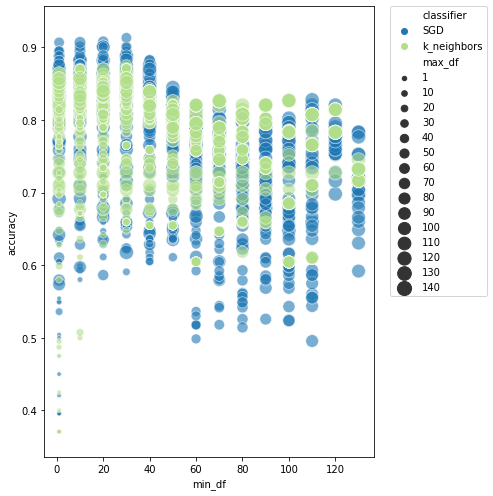

In [36]:
plt.figure(figsize=(7,7))
sns.scatterplot(data=df_copy, x='min_df', y='accuracy', hue = 'classifier', size='max_df', sizes=(20, 200), alpha=.6, legend='full', palette=['#1f78b4', '#b2df8a'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout() 
plt.savefig('images/KFold/2.1.1_exp4.png')

#### 2.1.2 accuracy-max_df-min_df

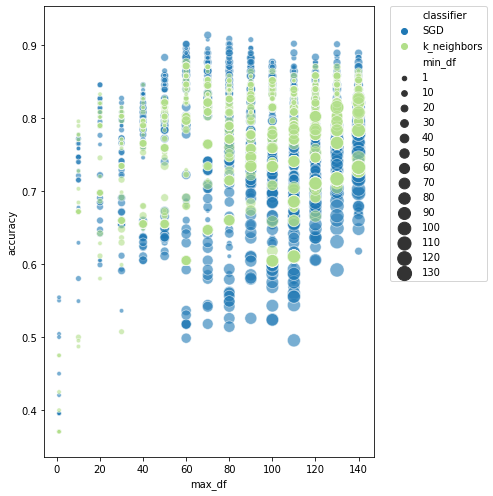

In [37]:
plt.figure(figsize=(7,7))
sns.scatterplot(data=df_copy, x='max_df', y='accuracy', hue = 'classifier', size='min_df', sizes=(20, 200), alpha=.6, legend='full', palette=['#1f78b4', '#b2df8a'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout() 
plt.savefig('images/KFold/2.1.2_exp4.png')

#### 2.1.3 accuracy-max_features-max_df

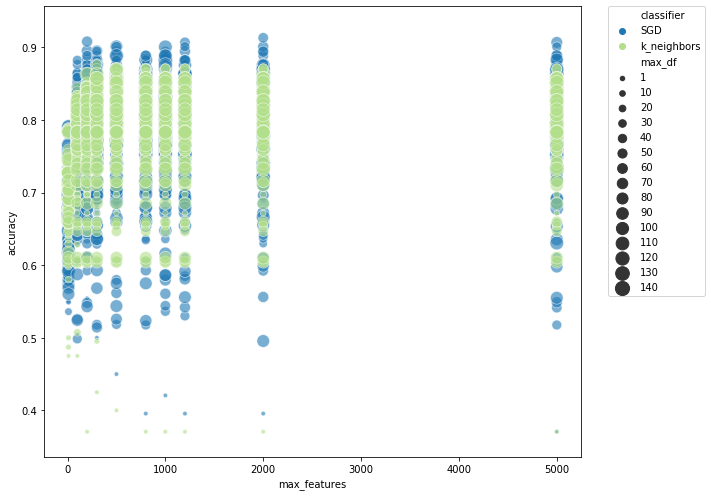

In [46]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df_copy, x='max_features', y='accuracy', hue = 'classifier', size='max_df', sizes=(20, 200), alpha=.6, legend='full', palette=['#1f78b4', '#b2df8a'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout() 
plt.savefig('images/KFold/2.1.3_exp4.png')

#### 2.1.4 accuracy-max_features-min_df

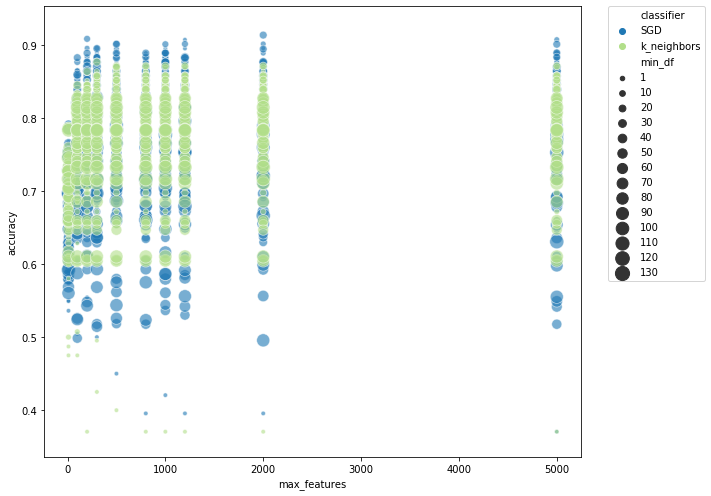

In [45]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df_copy, x='max_features', y='accuracy', hue = 'classifier', size='min_df', sizes=(20, 200), alpha=.6, legend='full', palette=['#1f78b4', '#b2df8a'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout() 
plt.savefig('images/KFold/2.1.4_exp4.png')

#### 2.1.5 min_df accuracy distribution

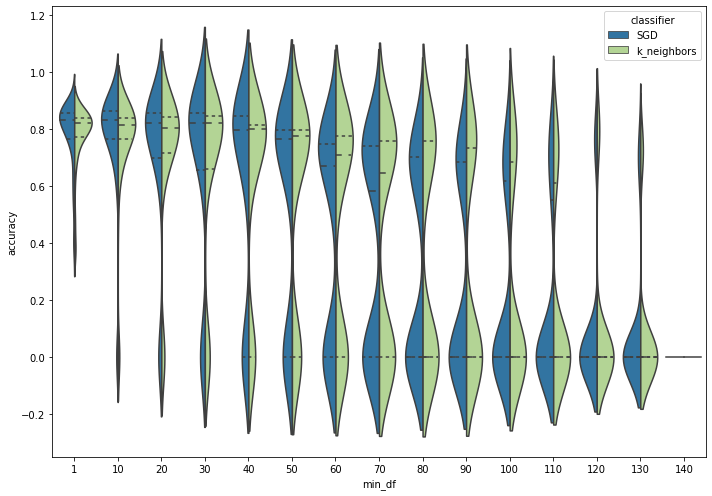

In [56]:
plt.figure(figsize=(10,7))
with sns.axes_style(style=None):
    sns.violinplot(x='min_df', y='accuracy', hue='classifier', data=df_7,
                   split=True, inner='quartile', palette=['#1f78b4', '#b2df8a']);
plt.tight_layout() 
plt.savefig('images/KFold/2.1.5_exp4.png')

#### 2.1.6 max_df accuracy distribution

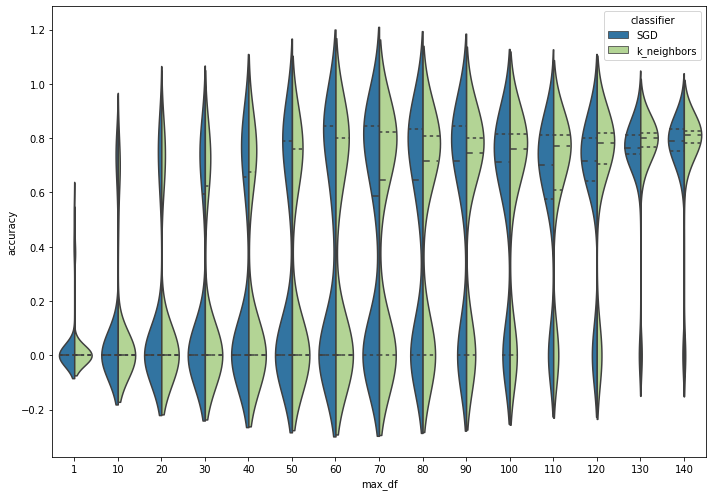

In [57]:
plt.figure(figsize=(10,7))
with sns.axes_style(style=None):
    sns.violinplot(x='max_df', y='accuracy', hue='classifier', data=df_7,
                   split=True, inner='quartile', palette=['#1f78b4', '#b2df8a']);
plt.tight_layout() 
plt.savefig('images/KFold/2.1.6_exp4.png')

### 2.2 Modify the parameter max_features, percentage(decimal) in min_df and percentage in max_df

In [25]:
data = {}

classifiers = {
    'SGD': SGDClassifier,
    'k_neighbors': KNeighborsClassifier}

features = [10,100,200,300,500,800,1000,1200,2000,5000]
df = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

#Step 1: set experiment configuration as dataframe index
for num in features:
    for min_df in df:
        for max_df in df:
            #Add configuration to data_frame
            column_name = 'f_'+str(num)+'_min_'+str(min_df)+'_max_'+str(max_df)
            if not 'configuration' in data:
                data['configuration'] = []
            data['configuration'].append(column_name)
            
#Step 2: find data
for name_classifier in classifiers:    
    print(data)
    print ('----------------------------------')
    print ('Classifier: ' + name_classifier)
    classifier = classifiers[name_classifier]()
    
    for num in features:
        for min_df in df:
            for max_df in df:
                
                try:
                    tfidfconverter = TfidfVectorizer(max_features=num, min_df=min_df, max_df=max_df, stop_words=stopwords.words('english'))
                    x = tfidfconverter.fit_transform(documents).toarray()

                    scores = cross_val_score(classifier,x,y,cv=10)

                    print('f_'+str(num)+'_min_'+str(min_df)+'_max_'+str(max_df))
                    print(scores)
                    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
                    
                    accuracy = scores.mean()
                    
                except Exception:
                    print('There was an error')
                    accuracy = 0
                    
                #Add data to column
                if not name_classifier in data:
                    data[name_classifier] = []
                data[name_classifier].append(accuracy)

df_8 = pd.DataFrame(data)
print(df_8)

{'configuration': ['f_10_min_0.1_max_0.1', 'f_10_min_0.1_max_0.2', 'f_10_min_0.1_max_0.3', 'f_10_min_0.1_max_0.4', 'f_10_min_0.1_max_0.5', 'f_10_min_0.1_max_0.6', 'f_10_min_0.1_max_0.7', 'f_10_min_0.1_max_0.8', 'f_10_min_0.1_max_0.9', 'f_10_min_0.2_max_0.1', 'f_10_min_0.2_max_0.2', 'f_10_min_0.2_max_0.3', 'f_10_min_0.2_max_0.4', 'f_10_min_0.2_max_0.5', 'f_10_min_0.2_max_0.6', 'f_10_min_0.2_max_0.7', 'f_10_min_0.2_max_0.8', 'f_10_min_0.2_max_0.9', 'f_10_min_0.3_max_0.1', 'f_10_min_0.3_max_0.2', 'f_10_min_0.3_max_0.3', 'f_10_min_0.3_max_0.4', 'f_10_min_0.3_max_0.5', 'f_10_min_0.3_max_0.6', 'f_10_min_0.3_max_0.7', 'f_10_min_0.3_max_0.8', 'f_10_min_0.3_max_0.9', 'f_10_min_0.4_max_0.1', 'f_10_min_0.4_max_0.2', 'f_10_min_0.4_max_0.3', 'f_10_min_0.4_max_0.4', 'f_10_min_0.4_max_0.5', 'f_10_min_0.4_max_0.6', 'f_10_min_0.4_max_0.7', 'f_10_min_0.4_max_0.8', 'f_10_min_0.4_max_0.9', 'f_10_min_0.5_max_0.1', 'f_10_min_0.5_max_0.2', 'f_10_min_0.5_max_0.3', 'f_10_min_0.5_max_0.4', 'f_10_min_0.5_max_0.5

There was an error
f_10_min_0.1_max_0.2
[0.58823529 0.47058824 0.5        0.5625     0.625      0.5625
 0.5        0.625      0.625      0.625     ]
Accuracy: 0.57 (+/- 0.11)
f_10_min_0.1_max_0.3
[0.64705882 0.64705882 0.5625     0.75       0.625      0.5
 0.625      0.75       0.8125     0.625     ]
Accuracy: 0.65 (+/- 0.18)
f_10_min_0.1_max_0.4
[0.88235294 0.64705882 0.6875     0.75       0.75       0.625
 0.6875     0.6875     0.625      0.6875    ]
Accuracy: 0.70 (+/- 0.15)
f_10_min_0.1_max_0.5
[0.52941176 0.76470588 0.75       0.5625     0.5625     0.6875
 0.75       0.625      0.6875     0.5625    ]
Accuracy: 0.65 (+/- 0.17)
f_10_min_0.1_max_0.6
[0.76470588 0.76470588 0.625      0.625      0.6875     0.75
 0.625      0.8125     0.75       0.6875    ]
Accuracy: 0.71 (+/- 0.13)
f_10_min_0.1_max_0.7
[0.76470588 0.64705882 0.5        0.625      0.4375     0.75
 0.75       0.75       0.875      0.625     ]
Accuracy: 0.67 (+/- 0.25)
f_10_min_0.1_max_0.8
[0.52941176 0.64705882 0.625    

f_100_min_0.2_max_0.6
[0.82352941 0.88235294 0.8125     0.8125     0.6875     0.875
 0.8125     0.8125     0.75       0.8125    ]
Accuracy: 0.81 (+/- 0.11)
f_100_min_0.2_max_0.7
[0.82352941 0.58823529 0.8125     0.8125     0.625      0.8125
 0.5625     0.75       0.75       0.8125    ]
Accuracy: 0.73 (+/- 0.20)
f_100_min_0.2_max_0.8
[0.82352941 0.64705882 0.625      0.8125     0.75       0.6875
 0.8125     0.75       0.75       0.8125    ]
Accuracy: 0.75 (+/- 0.14)
f_100_min_0.2_max_0.9
[0.88235294 0.76470588 0.625      0.875      0.75       0.75
 0.6875     0.875      0.75       0.875     ]
Accuracy: 0.78 (+/- 0.17)
There was an error
There was an error
There was an error
f_100_min_0.3_max_0.4
[0.88235294 0.76470588 0.8125     0.8125     0.875      0.6875
 0.75       0.8125     0.8125     0.6875    ]
Accuracy: 0.79 (+/- 0.13)
f_100_min_0.3_max_0.5
[0.88235294 0.82352941 0.75       0.8125     0.8125     0.875
 0.75       0.8125     0.8125     0.6875    ]
Accuracy: 0.80 (+/- 0.11)
f_100

There was an error
There was an error
There was an error
There was an error
f_200_min_0.4_max_0.5
[0.88235294 0.58823529 0.625      0.6875     0.75       0.875
 0.75       0.875      0.6875     0.625     ]
Accuracy: 0.73 (+/- 0.21)
f_200_min_0.4_max_0.6
[0.88235294 0.70588235 0.625      0.75       0.8125     0.8125
 0.8125     0.75       0.625      0.8125    ]
Accuracy: 0.76 (+/- 0.16)
f_200_min_0.4_max_0.7
[0.94117647 0.58823529 0.625      0.75       0.8125     0.75
 0.9375     0.875      0.5625     0.75      ]
Accuracy: 0.76 (+/- 0.26)
f_200_min_0.4_max_0.8
[0.94117647 0.70588235 0.5625     0.6875     0.8125     0.6875
 0.875      0.875      0.75       0.6875    ]
Accuracy: 0.76 (+/- 0.22)
f_200_min_0.4_max_0.9
[0.94117647 0.82352941 0.6875     0.875      0.875      0.8125
 0.75       0.9375     0.625      0.875     ]
Accuracy: 0.82 (+/- 0.20)
There was an error
There was an error
There was an error
There was an error
f_200_min_0.5_max_0.5
[0.70588235 0.64705882 0.4375     0.375     

There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_300_min_0.6_max_0.7
[0.94117647 0.52941176 0.6875     0.6875     0.5        0.75
 0.75       0.8125     0.75       0.625     ]
Accuracy: 0.70 (+/- 0.25)
f_300_min_0.6_max_0.8
[0.76470588 0.52941176 0.5        0.75       0.75       0.6875
 0.8125     0.8125     0.8125     0.8125    ]
Accuracy: 0.72 (+/- 0.22)
f_300_min_0.6_max_0.9
[0.76470588 0.70588235 0.625      0.875      0.75       0.6875
 0.875      0.875      0.875      0.875     ]
Accuracy: 0.79 (+/- 0.18)
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_300_min_0.7_max_0.8
[0.88235294 0.52941176 0.625      0.8125     0.75       0.6875
 0.625      0.75       0.8125     0.75      ]
Accuracy: 0.72 (+/- 0.20)
f_300_min_0.7_max_0.9
[0.82352941 0.76470588 0.8125     0.875      0.8125     0.6875
 0.8125     0.6875     0.625      0.875   

f_800_min_0.1_max_0.3
[0.82352941 0.88235294 0.8125     0.75       0.8125     0.8125
 0.75       0.9375     0.8125     0.75      ]
Accuracy: 0.81 (+/- 0.11)
f_800_min_0.1_max_0.4
[0.88235294 0.94117647 0.875      0.875      0.875      0.8125
 0.8125     0.875      0.8125     0.875     ]
Accuracy: 0.86 (+/- 0.08)
f_800_min_0.1_max_0.5
[0.88235294 0.94117647 0.875      0.8125     0.9375     0.875
 0.875      0.6875     0.9375     0.75      ]
Accuracy: 0.86 (+/- 0.16)
f_800_min_0.1_max_0.6
[0.88235294 0.88235294 0.875      0.875      0.75       0.875
 0.75       0.875      0.8125     0.875     ]
Accuracy: 0.85 (+/- 0.10)
f_800_min_0.1_max_0.7
[0.94117647 0.82352941 0.875      0.8125     0.9375     0.8125
 0.875      0.875      0.75       0.875     ]
Accuracy: 0.86 (+/- 0.11)
f_800_min_0.1_max_0.8
[0.94117647 0.88235294 0.875      0.8125     0.875      0.875
 0.8125     0.875      0.875      0.8125    ]
Accuracy: 0.86 (+/- 0.08)
f_800_min_0.1_max_0.9
[0.94117647 0.88235294 0.9375     0.937

f_1000_min_0.2_max_0.6
[0.94117647 0.94117647 0.875      0.8125     0.875      0.9375
 0.8125     1.         0.9375     0.8125    ]
Accuracy: 0.89 (+/- 0.13)
f_1000_min_0.2_max_0.7
[0.94117647 0.76470588 0.8125     0.8125     0.6875     0.875
 0.875      0.875      0.875      0.8125    ]
Accuracy: 0.83 (+/- 0.14)
f_1000_min_0.2_max_0.8
[0.94117647 0.88235294 0.75       0.8125     0.8125     0.8125
 0.9375     0.8125     0.75       0.8125    ]
Accuracy: 0.83 (+/- 0.13)
f_1000_min_0.2_max_0.9
[0.94117647 0.88235294 0.75       0.875      0.8125     0.8125
 0.6875     0.875      0.875      0.875     ]
Accuracy: 0.84 (+/- 0.14)
There was an error
There was an error
There was an error
f_1000_min_0.3_max_0.4
[0.82352941 0.70588235 0.8125     0.875      0.875      0.75
 0.8125     0.875      0.875      0.875     ]
Accuracy: 0.83 (+/- 0.11)
f_1000_min_0.3_max_0.5
[0.88235294 0.76470588 0.75       0.8125     0.875      0.875
 0.75       0.875      0.75       0.75      ]
Accuracy: 0.81 (+/- 0.12)

There was an error
There was an error
There was an error
There was an error
f_1200_min_0.4_max_0.5
[0.88235294 0.58823529 0.625      0.625      0.8125     0.875
 0.75       0.9375     0.625      0.625     ]
Accuracy: 0.73 (+/- 0.25)
f_1200_min_0.4_max_0.6
[0.88235294 0.76470588 0.625      0.625      0.8125     0.8125
 0.8125     0.75       0.4375     0.625     ]
Accuracy: 0.71 (+/- 0.25)
f_1200_min_0.4_max_0.7
[0.94117647 0.58823529 0.5625     0.6875     0.875      0.625
 0.9375     0.875      0.6875     0.6875    ]
Accuracy: 0.75 (+/- 0.28)
f_1200_min_0.4_max_0.8
[0.76470588 0.70588235 0.5625     0.8125     0.75       0.75
 0.875      0.875      0.75       0.75      ]
Accuracy: 0.76 (+/- 0.17)
f_1200_min_0.4_max_0.9
[0.82352941 0.76470588 0.6875     0.8125     0.8125     0.8125
 0.75       0.9375     0.6875     0.8125    ]
Accuracy: 0.79 (+/- 0.14)
There was an error
There was an error
There was an error
There was an error
f_1200_min_0.5_max_0.5
[0.58823529 0.64705882 0.625      0.562

f_2000_min_0.5_max_0.9
[0.88235294 0.70588235 0.6875     0.75       0.8125     0.75
 0.75       0.8125     0.625      0.8125    ]
Accuracy: 0.76 (+/- 0.14)
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_2000_min_0.6_max_0.7
[0.94117647 0.47058824 0.625      0.75       0.5625     0.6875
 0.75       0.875      0.75       0.5625    ]
Accuracy: 0.70 (+/- 0.28)
f_2000_min_0.6_max_0.8
[0.88235294 0.64705882 0.6875     0.75       0.6875     0.625
 0.8125     0.8125     0.875      0.6875    ]
Accuracy: 0.75 (+/- 0.18)
f_2000_min_0.6_max_0.9
[0.82352941 0.64705882 0.5625     0.8125     0.6875     0.6875
 0.6875     0.8125     0.75       0.875     ]
Accuracy: 0.73 (+/- 0.18)
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_2000_min_0.7_max_0.8
[0.64705882 0.58823529 0.5625     0.625      0.75       0.6875
 0.75       0.6875     0.6875     0.81

There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
{'configuration': ['f_10_min_0.1_max_0.1', 'f_10_min_0.1_max_0.2', 'f_10_min_0.1_max_0.3', 'f_10_min_0.1_max_0.4', 'f_10_min_0.1_max_0.5', 'f_10_min_0.1_max_0.6', 'f_10_min_0.1_max_0.7', 'f_10_min_0.1_max_0.8', 'f_10_min_0.1_max_0.9', 'f_10_min_0.2_max_0.1', 'f_10_min_0.2_max_0.2', 'f_10_min_0.2_max_0.3', 'f_10_min_0.2_max_0.4', 'f_10_min_0.2_max_0.5', 'f_10_min_0.2_max_0.6', 'f_10_min_0.2_max_0.7', 'f_10_min_0.2_max_0.8', 'f_10_min_0.2_max_0.9', 'f_10_min_0.3_max_0.1', 'f_10_min_0.3_max_0.2', 'f_10_min_0.3_max_0.3', 'f_10_min_0.3_max_0.4', 'f_10_min_0.3_max_0.5', 'f_10_min_0.3_max_0.6', 'f_10_min_0.3_max_0.7', 'f_10_min_0.3_max_0.8', 'f_10_min_0.3_max_0.9', 'f_10_min_0.4_max_0.1', 'f_10_min_0.4_max_0.2', 'f_10_min_0.4_max_0.3', 'f_10_min_0.4_max_0.4', 'f_10_min_0.4_max_0.5', 'f_10_min_0.4_max_0.6', 'f_10_min_0.4_max_0.7', 'f_10_min_0.4_max_0.8', 'f_10_min_0.4_max_0.9', 'f_

There was an error
f_10_min_0.1_max_0.2
[0.58823529 0.58823529 0.75       0.625      0.625      0.625
 0.5625     0.8125     0.5625     0.5       ]
Accuracy: 0.62 (+/- 0.18)
f_10_min_0.1_max_0.3
[0.64705882 0.70588235 0.5625     0.5625     0.6875     0.625
 0.6875     0.875      0.8125     0.6875    ]
Accuracy: 0.69 (+/- 0.19)
f_10_min_0.1_max_0.4
[0.88235294 0.58823529 0.75       0.75       0.625      0.75
 0.75       0.625      0.75       0.75      ]
Accuracy: 0.72 (+/- 0.16)
f_10_min_0.1_max_0.5
[0.94117647 0.88235294 0.875      0.8125     0.625      0.6875
 0.8125     0.75       0.6875     0.6875    ]
Accuracy: 0.78 (+/- 0.20)
f_10_min_0.1_max_0.6
[0.88235294 0.88235294 0.6875     0.6875     0.75       0.8125
 0.8125     0.75       0.6875     0.5625    ]
Accuracy: 0.75 (+/- 0.19)
f_10_min_0.1_max_0.7
[0.88235294 0.64705882 0.625      0.625      0.8125     0.5625
 0.8125     0.6875     0.9375     0.5625    ]
Accuracy: 0.72 (+/- 0.26)
f_10_min_0.1_max_0.8
[0.76470588 0.64705882 0.812

f_100_min_0.2_max_0.5
[0.82352941 0.88235294 0.75       0.8125     0.6875     0.8125
 0.75       0.8125     0.75       0.6875    ]
Accuracy: 0.78 (+/- 0.12)
f_100_min_0.2_max_0.6
[1.         0.88235294 0.875      0.8125     0.6875     0.875
 0.8125     0.75       0.8125     0.75      ]
Accuracy: 0.83 (+/- 0.17)
f_100_min_0.2_max_0.7
[0.94117647 0.82352941 0.8125     0.75       0.5625     0.9375
 0.875      0.8125     0.875      0.75      ]
Accuracy: 0.81 (+/- 0.21)
f_100_min_0.2_max_0.8
[0.94117647 0.82352941 0.8125     0.75       0.6875     0.875
 0.6875     0.8125     0.875      0.75      ]
Accuracy: 0.80 (+/- 0.16)
f_100_min_0.2_max_0.9
[0.94117647 0.88235294 0.6875     0.9375     0.8125     0.875
 0.6875     0.875      0.75       0.75      ]
Accuracy: 0.82 (+/- 0.18)
There was an error
There was an error
There was an error
f_100_min_0.3_max_0.4
[0.88235294 0.76470588 0.8125     0.75       0.8125     0.875
 0.8125     0.875      0.875      0.8125    ]
Accuracy: 0.83 (+/- 0.09)
f_100

f_200_min_0.3_max_0.9
[0.94117647 0.88235294 0.6875     0.875      0.8125     0.875
 0.625      0.9375     0.75       0.75      ]
Accuracy: 0.81 (+/- 0.20)
There was an error
There was an error
There was an error
There was an error
f_200_min_0.4_max_0.5
[0.94117647 0.76470588 0.75       0.6875     0.75       0.875
 0.8125     0.6875     0.625      0.75      ]
Accuracy: 0.76 (+/- 0.18)
f_200_min_0.4_max_0.6
[0.94117647 0.76470588 0.6875     0.75       0.75       0.875
 0.8125     0.6875     0.6875     0.75      ]
Accuracy: 0.77 (+/- 0.16)
f_200_min_0.4_max_0.7
[0.88235294 0.82352941 0.75       0.6875     0.8125     0.8125
 0.6875     0.875      0.8125     0.75      ]
Accuracy: 0.79 (+/- 0.13)
f_200_min_0.4_max_0.8
[0.94117647 0.76470588 0.6875     0.8125     0.75       0.875
 0.625      0.875      0.875      0.75      ]
Accuracy: 0.80 (+/- 0.19)
f_200_min_0.4_max_0.9
[0.94117647 0.88235294 0.75       0.75       0.8125     0.875
 0.6875     0.9375     0.75       0.75      ]
Accuracy: 0.8

f_300_min_0.5_max_0.9
[0.94117647 0.76470588 0.6875     0.9375     0.875      0.9375
 0.625      0.9375     0.6875     0.75      ]
Accuracy: 0.81 (+/- 0.24)
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_300_min_0.6_max_0.7
[0.88235294 0.76470588 0.8125     0.5625     0.625      0.75
 0.8125     0.875      0.75       0.625     ]
Accuracy: 0.75 (+/- 0.21)
f_300_min_0.6_max_0.8
[0.94117647 0.76470588 0.75       0.875      0.6875     0.9375
 0.75       0.9375     0.75       0.6875    ]
Accuracy: 0.81 (+/- 0.20)
f_300_min_0.6_max_0.9
[0.88235294 0.76470588 0.75       0.875      0.875      0.875
 0.6875     0.9375     0.6875     0.75      ]
Accuracy: 0.81 (+/- 0.17)
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_300_min_0.7_max_0.8
[0.82352941 0.82352941 0.625      0.9375     0.6875     0.75
 0.625      0.625      0.75       0.9375    ]

There was an error
There was an error
There was an error
There was an error
There was an error
f_800_min_0.1_max_0.2
[0.82352941 0.76470588 0.8125     0.6875     0.625      0.6875
 0.8125     0.8125     0.75       0.625     ]
Accuracy: 0.74 (+/- 0.15)
f_800_min_0.1_max_0.3
[0.88235294 0.76470588 0.875      0.75       0.625      0.75
 0.8125     0.875      0.75       0.8125    ]
Accuracy: 0.79 (+/- 0.15)
f_800_min_0.1_max_0.4
[0.88235294 0.82352941 0.9375     0.875      0.8125     0.875
 0.8125     0.9375     0.875      0.75      ]
Accuracy: 0.86 (+/- 0.11)
f_800_min_0.1_max_0.5
[0.88235294 0.88235294 0.9375     0.8125     0.75       0.6875
 0.8125     0.875      0.75       0.75      ]
Accuracy: 0.81 (+/- 0.15)
f_800_min_0.1_max_0.6
[0.88235294 0.88235294 0.9375     0.875      0.8125     0.6875
 0.8125     0.9375     0.8125     0.75      ]
Accuracy: 0.84 (+/- 0.15)
f_800_min_0.1_max_0.7
[0.88235294 0.82352941 0.9375     0.875      0.8125     0.75
 0.875      0.9375     0.8125     0.75  

f_1000_min_0.2_max_0.5
[0.88235294 1.         0.875      0.75       0.6875     0.6875
 0.8125     0.875      0.875      0.8125    ]
Accuracy: 0.83 (+/- 0.18)
f_1000_min_0.2_max_0.6
[0.88235294 1.         0.875      0.8125     0.6875     0.625
 0.8125     1.         0.875      0.8125    ]
Accuracy: 0.84 (+/- 0.23)
f_1000_min_0.2_max_0.7
[0.88235294 0.82352941 0.9375     0.875      0.8125     0.625
 0.8125     0.875      0.875      0.8125    ]
Accuracy: 0.83 (+/- 0.16)
f_1000_min_0.2_max_0.8
[0.94117647 0.82352941 0.875      0.9375     0.8125     0.8125
 0.8125     0.9375     0.875      0.875     ]
Accuracy: 0.87 (+/- 0.10)
f_1000_min_0.2_max_0.9
[0.94117647 0.82352941 0.9375     0.875      0.8125     0.875
 0.6875     1.         0.875      0.75      ]
Accuracy: 0.86 (+/- 0.18)
There was an error
There was an error
There was an error
f_1000_min_0.3_max_0.4
[0.82352941 0.76470588 0.75       0.75       0.875      0.875
 0.8125     0.875      0.8125     0.8125    ]
Accuracy: 0.82 (+/- 0.09)

f_1200_min_0.3_max_0.9
[0.94117647 0.82352941 0.75       0.8125     0.8125     0.8125
 0.625      0.9375     0.75       0.75      ]
Accuracy: 0.80 (+/- 0.18)
There was an error
There was an error
There was an error
There was an error
f_1200_min_0.4_max_0.5
[0.94117647 0.76470588 0.75       0.6875     0.75       0.875
 0.8125     0.6875     0.625      0.75      ]
Accuracy: 0.76 (+/- 0.18)
f_1200_min_0.4_max_0.6
[0.94117647 0.76470588 0.6875     0.75       0.75       0.875
 0.8125     0.6875     0.6875     0.75      ]
Accuracy: 0.77 (+/- 0.16)
f_1200_min_0.4_max_0.7
[0.88235294 0.82352941 0.75       0.6875     0.8125     0.8125
 0.6875     0.875      0.8125     0.75      ]
Accuracy: 0.79 (+/- 0.13)
f_1200_min_0.4_max_0.8
[0.94117647 0.76470588 0.6875     0.8125     0.75       0.875
 0.625      0.875      0.875      0.75      ]
Accuracy: 0.80 (+/- 0.19)
f_1200_min_0.4_max_0.9
[0.94117647 0.82352941 0.75       0.75       0.8125     0.875
 0.6875     0.9375     0.75       0.75      ]
Accura

f_2000_min_0.5_max_0.8
[0.82352941 0.82352941 0.625      0.875      0.75       0.8125
 0.6875     0.875      0.75       0.75      ]
Accuracy: 0.78 (+/- 0.15)
f_2000_min_0.5_max_0.9
[0.94117647 0.76470588 0.6875     0.9375     0.875      0.9375
 0.625      0.9375     0.6875     0.75      ]
Accuracy: 0.81 (+/- 0.24)
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
f_2000_min_0.6_max_0.7
[0.88235294 0.76470588 0.8125     0.5625     0.625      0.75
 0.8125     0.875      0.75       0.625     ]
Accuracy: 0.75 (+/- 0.21)
f_2000_min_0.6_max_0.8
[0.94117647 0.76470588 0.75       0.875      0.6875     0.9375
 0.75       0.9375     0.75       0.6875    ]
Accuracy: 0.81 (+/- 0.20)
f_2000_min_0.6_max_0.9
[0.88235294 0.76470588 0.75       0.875      0.875      0.875
 0.6875     0.9375     0.6875     0.75      ]
Accuracy: 0.81 (+/- 0.17)
There was an error
There was an error
There was an error
There was an error
There was an error
Ther

There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
There was an error
              configuration       SGD  k_neighbors
0      f_10_min_0.1_max_0.1  0.000000     0.000000
1      f_10_min_0.1_max_0.2  0.568382     0.623897
2      f_10_min_0.1_max_0.3  0.654412     0.685294
3      f_10_min_0.1_max_0.4  0.702941     0.722059
4      f_10_min_0.1_max_0.5  0.648162     0.776103
..                      ...       ...          ...
805  f_5000_min_0.9_max_0.5  0.000000     0.000000
806  f_5000_min_0.9_max_0.6  0.000000     0.000000
807  f_5000_min_0.9_max_0.7  0.000000     0.000000
808  f_5000_min_0.9_max_0.8  0.000000     0.000000
809  f_5000_min_0.9_max_0.9  0.000000     0.000000

[810 rows x 3 columns]


In [26]:
data = {}

features = [10,100,200,300,500,800,1000,1200,2000,5000]
df = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

classifiers = ['SGD', 'k_neighbors']


for classifier in classifiers:    
    for num in features:
        for min_df in df:
            for max_df in df:
                
                if not 'classifier' in data:
                    data['classifier'] = []
                data['classifier'].append(classifier)
                
                if not 'max_features' in data:
                    data['max_features'] = []
                data['max_features'].append(num)
                
                if not 'min_df' in data:
                    data['min_df'] = []
                data['min_df'].append(min_df)
                
                if not 'max_df' in data:
                    data['max_df'] = []
                data['max_df'].append(max_df)
                
for classifier in classifiers:
    for value in df_8[classifier]:
        if not 'accuracy' in data:
            data['accuracy'] = []
        data['accuracy'].append(value)               
                      
df_9 = pd.DataFrame(data)
df_9.to_excel("output_decimals.xlsx")

In [47]:
df_copy_d = df_9
df_copy_d= df_copy_d[df_copy_d['accuracy'] != 0]
df_copy_d.to_excel('output_decimals_no_zeroes.xlsx')

#### 2.2.1 accuracy-min_df-max_df

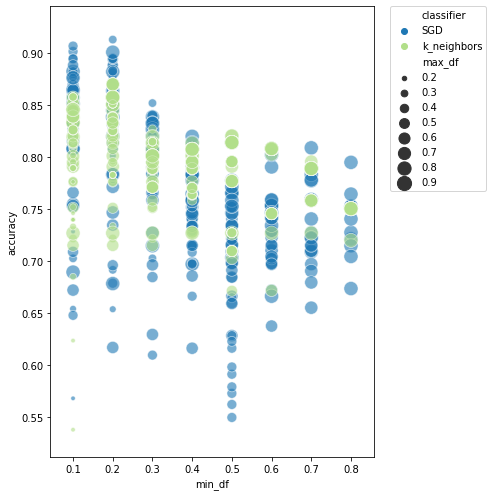

In [48]:
plt.figure(figsize=(7,7))
sns.scatterplot(data=df_copy_d, x='min_df', y='accuracy', hue = 'classifier', size='max_df', sizes=(20, 200), alpha=.6, legend='full', palette=['#1f78b4', '#b2df8a'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout() 
plt.savefig('images/KFold/2.2.1_exp4.png')

#### 2.2.2 accuracy-max_df-min_df

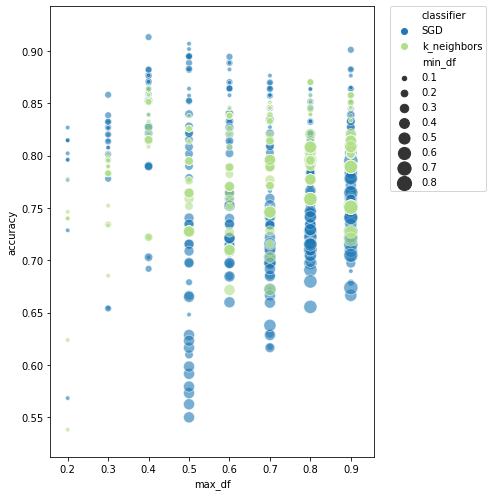

In [49]:
plt.figure(figsize=(7,7))
sns.scatterplot(data=df_copy_d, x='max_df', y='accuracy', hue = 'classifier', size='min_df', sizes=(20, 200), alpha=.6, legend='full', palette=['#1f78b4', '#b2df8a'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout() 
plt.savefig('images/KFold/2.2.2_exp4.png')

#### 2.2.3 accuracy-max_features-max_df

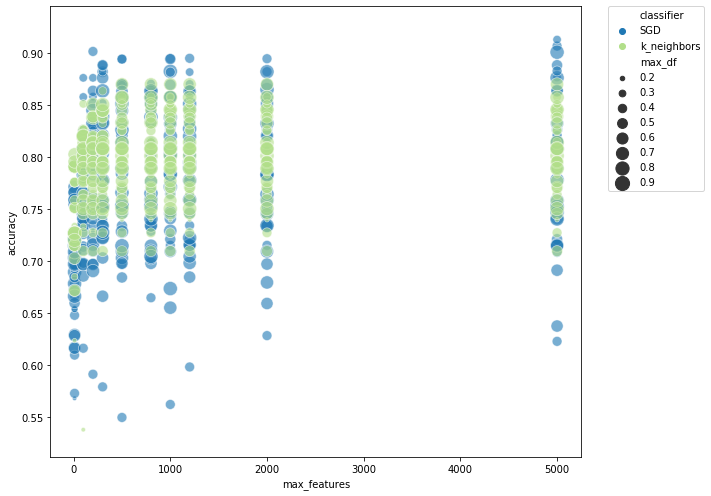

In [50]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df_copy_d, x='max_features', y='accuracy', hue = 'classifier', size='max_df', sizes=(20, 200), alpha=.6, legend='full', palette=['#1f78b4', '#b2df8a'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout() 
plt.savefig('images/KFold/2.2.3_exp4.png')

#### 2.2.4 accuracy-max_features-min_df

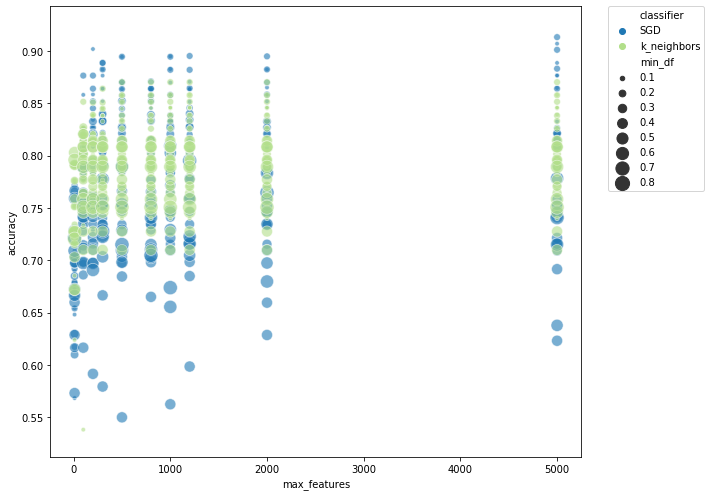

In [51]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df_copy_d, x='max_features', y='accuracy', hue = 'classifier', size='min_df', sizes=(20, 200), alpha=.6, legend='full', palette=['#1f78b4', '#b2df8a'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout() 
plt.savefig('images/KFold/2.2.4_exp4.png')

#### 2.2.5 min_df accuracy distribution

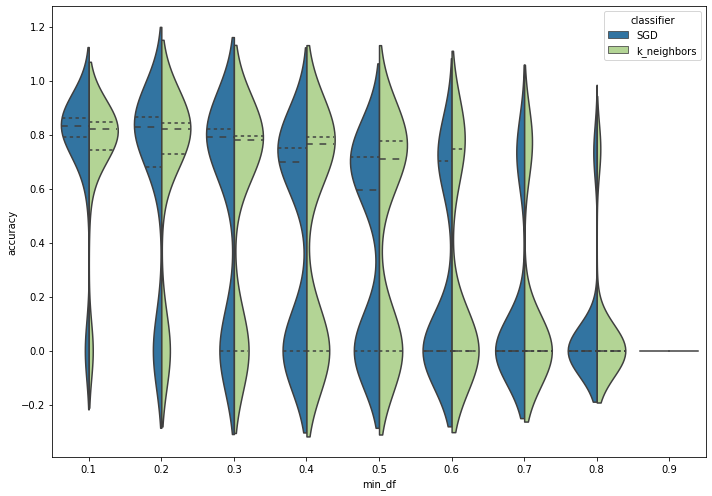

In [58]:
plt.figure(figsize=(10,7))
with sns.axes_style(style=None):
    sns.violinplot(x='min_df', y='accuracy', hue='classifier', data=df_9,
                   split=True, inner='quartile', palette=['#1f78b4', '#b2df8a']);
plt.tight_layout() 
plt.savefig('images/KFold/2.2.5_exp4.png')

#### 2.2.6 max_df accuracy distribution

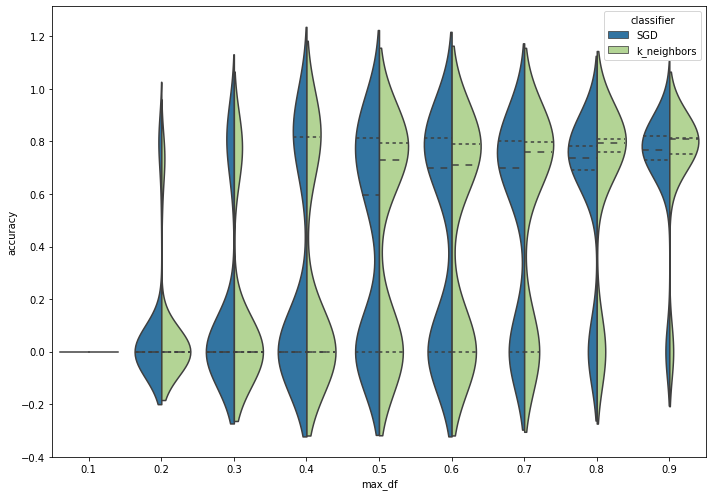

In [59]:
plt.figure(figsize=(10,7))
with sns.axes_style(style=None):
    sns.violinplot(x='max_df', y='accuracy', hue='classifier', data=df_9,
                   split=True, inner='quartile', palette=['#1f78b4', '#b2df8a']);
plt.tight_layout() 
plt.savefig('images/KFold/2.2.6_exp4.png')